# GNN - Exercise 2

**Team members:**
- Pratik Goyal
- Rohit Sonejee

---

## Task 1: Two-dimensional data with bottleneck

In [82]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, load_digits
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')


In [83]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [84]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [85]:
# 1. AUTOENCODER IMPLEMENTATIONS
# ============================================================================

class VanillaAutoencoder(nn.Module):
    """Vanilla autoencoder with configurable architecture."""
    
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_size
        
        # Hidden layers
        for _ in range(layers):
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_size),
                nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Bottleneck
        encoder_layers.append(nn.Linear(prev_dim, bottleneck_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder (mirror of encoder)
        decoder_layers = []
        prev_dim = bottleneck_size
        
        # Hidden layers
        for _ in range(layers):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_size),
                nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Output layer (no ReLU)
        decoder_layers.append(nn.Linear(prev_dim, input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return reconstructed, code
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, code):
        return self.decoder(code)


class ResNetAutoencoder(nn.Module):
    """ResNet-based autoencoder for better MMD training."""
    
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        
        # Initial projection
        self.input_proj = nn.Linear(input_size, hidden_size)
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            self._make_res_block(hidden_size) for _ in range(layers)
        ])
        
        # Bottleneck
        self.bottleneck = nn.Linear(hidden_size, bottleneck_size)
        
        # Decoder
        self.decoder_input = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_res_blocks = nn.ModuleList([
            self._make_res_block(hidden_size) for _ in range(layers)
        ])
        self.output_proj = nn.Linear(hidden_size, input_size)
    
    def _make_res_block(self, dim):
        return nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    
    def forward(self, x):
        code = self.encode(x)
        reconstructed = self.decode(code)
        return reconstructed, code
    
    def encode(self, x):
        z = self.input_proj(x)
        for block in self.res_blocks:
            z = z + block(z)
        code = self.bottleneck(z)
        return code
    
    def decode(self, code):
        z = self.decoder_input(code)
        for block in self.decoder_res_blocks:
            z = z + block(z)
        return self.output_proj(z)


In [86]:
# 2. MMD LOSS IMPLEMENTATION
# ============================================================================

class MMDLoss(nn.Module):
    """Maximum Mean Discrepancy loss with multiple kernel bandwidths."""
    
    def __init__(self, kernel_type='rbf', bandwidths=None):
        super().__init__()
        self.kernel_type = kernel_type
        
        if bandwidths is None:
            # Default bandwidths: geometric progression
            self.bandwidths = [0.5, 1.0, 2.0, 4.0, 8.0]
        else:
            self.bandwidths = bandwidths
    
    def kernel(self, x, y, bandwidth):
        """Compute kernel matrix between x and y."""
        dist_sq = torch.cdist(x, y, p=2) ** 2
        
        if self.kernel_type == 'rbf':
            # RBF kernel: exp(-||x-y||² / (2σ²))
            return torch.exp(-dist_sq / (2 * bandwidth ** 2))
        elif self.kernel_type == 'imq':
            # Inverse multiquadratic: 1 / sqrt(||x-y||² + σ²)
            return 1.0 / torch.sqrt(dist_sq + bandwidth ** 2)
        else:
            raise ValueError(f"Unknown kernel type: {self.kernel_type}")
    
    def forward(self, x, y):
        """Compute MMD between distributions x and y."""
        mmd = 0.0
        
        for bandwidth in self.bandwidths:
            # Kernel matrices
            k_xx = self.kernel(x, x, bandwidth)
            k_yy = self.kernel(y, y, bandwidth)
            k_xy = self.kernel(x, y, bandwidth)
            
            # Remove diagonal for unbiased estimate
            n = x.size(0)
            m = y.size(0)
            k_xx = k_xx - torch.diag_embed(torch.diag(k_xx))
            k_yy = k_yy - torch.diag_embed(torch.diag(k_yy))
            
            mmd += (k_xx.sum() / (n * (n - 1)) + 
                   k_yy.sum() / (m * (m - 1)) - 
                   2 * k_xy.mean())
        
        return mmd / len(self.bandwidths)


In [87]:
# 3. TRAINING FUNCTIONS
# ============================================================================

def train_autoencoder(model, train_loader, test_loader, epochs=100, lr=0.001):
    """Train vanilla autoencoder with MSE loss."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device).float()
            
            optimizer.zero_grad()
            reconstructed, _ = model(batch_x)
            loss = criterion(reconstructed, batch_x)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_x, _ in test_loader:
                batch_x = batch_x.to(device).float()
                reconstructed, _ = model(batch_x)
                loss = criterion(reconstructed, batch_x)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
    
    return model, train_losses, test_losses


def train_mmd_autoencoder(model, train_loader, test_loader, epochs=150, lr=0.001, 
                           mmd_weight=0.1, kernel_type='rbf'):
    """Train autoencoder with MMD regularization."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_criterion = nn.MSELoss()
    mmd_criterion = MMDLoss(kernel_type=kernel_type)
    
    train_losses = []
    test_losses = []
    mmd_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        mmd_loss = 0.0
        
        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device).float()
            
            optimizer.zero_grad()
            reconstructed, code = model(batch_x)
            
            # MSE loss
            mse_loss = mse_criterion(reconstructed, batch_x)
            
            # MMD loss: code vs standard normal
            z = torch.randn_like(code)
            mmd = mmd_criterion(code, z)
            
            # Total loss
            total_loss = mse_loss + mmd_weight * mmd
            total_loss.backward()
            optimizer.step()
            
            train_loss += mse_loss.item()
            mmd_loss += mmd.item()
        
        train_loss /= len(train_loader)
        mmd_loss /= len(train_loader)
        train_losses.append(train_loss)
        mmd_losses.append(mmd_loss)
        
        # Testing
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_x, _ in test_loader:
                batch_x = batch_x.to(device).float()
                reconstructed, _ = model(batch_x)
                loss = mse_criterion(reconstructed, batch_x)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch+1}/{epochs}, MSE: {train_loss:.6f}, MMD: {mmd_loss:.6f}, Test MSE: {test_loss:.6f}")
    
    return model, train_losses, test_losses, mmd_losses



In [88]:
# 4. DATA UTILITIES
# ============================================================================

def create_moons_data(n_samples=2000, noise=0.1, test_size=0.2, batch_size=64):
    """Create train/test loaders for moons dataset."""
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    # Convert to tensors
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).long()
    )
    test_dataset = TensorDataset(
        torch.from_numpy(X_test).float(),
        torch.from_numpy(y_test).long()
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, X_test, y_test


def create_digits_data(test_size=0.2, batch_size=64):
    """Create train/test loaders for digits dataset."""
    digits = load_digits()
    X = digits.data.astype(np.float32) / 16.0  # Normalize to [0, 1]
    y = digits.target
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).long()
    )
    test_dataset = TensorDataset(
        torch.from_numpy(X_test).float(),
        torch.from_numpy(y_test).long()
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, X_test, y_test, digits.images[0].shape



In [89]:
# 5. VISUALIZATION UTILITIES
# ============================================================================

def plot_reconstruction(X_test, y_test, model, title=""):
    """Plot original vs reconstructed data."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X_test).float().to(device)
        X_recon, _ = model(X_tensor)
        X_recon = X_recon.cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original
    axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', s=20, alpha=0.6)
    axes[0].set_title(f"Original Data - {title}")
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")
    
    # Reconstructed
    axes[1].scatter(X_recon[:, 0], X_recon[:, 1], c=y_test, cmap='viridis', s=20, alpha=0.6)
    axes[1].set_title(f"Reconstructed Data - {title}")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")
    
    plt.tight_layout()
    plt.show()
    
    return np.mean((X_test - X_recon) ** 2)


def plot_code_distribution(codes, labels, title=""):
    """Plot histogram or scatter of code distribution."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if codes.shape[1] == 1:
        # 1D bottleneck: histogram
        ax.hist(codes.flatten(), bins=50, alpha=0.7, edgecolor='black')
        ax.set_title(f"Code Distribution Histogram - {title}")
        ax.set_xlabel("Code Value")
        ax.set_ylabel("Frequency")
    else:
        # 2D bottleneck: scatter plot
        scatter = ax.scatter(codes[:, 0], codes[:, 1], c=labels, cmap='tab10', 
                            alpha=0.6, s=20)
        ax.set_title(f"Code Distribution - {title}")
        ax.set_xlabel("Code Dimension 1")
        ax.set_ylabel("Code Dimension 2")
        plt.colorbar(scatter, ax=ax, label='Class')
    
    plt.tight_layout()
    plt.show()


def plot_hyperparameter_analysis(hyperparams, losses, param_name, title=""):
    """Plot reconstruction error vs hyperparameter."""
    plt.figure(figsize=(8, 6))
    plt.plot(hyperparams, losses, marker='o', linewidth=2)
    plt.title(f"Test Reconstruction Error vs {param_name}\n{title}")
    plt.xlabel(param_name)
    plt.ylabel("MSE Reconstruction Error")
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_synthetic_vs_original(X_original, X_synthetic, title=""):
    """Compare original and synthetic data distributions."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].scatter(X_original[:, 0], X_original[:, 1], alpha=0.5, s=20, label='Original')
    axes[0].set_title(f"Original Data - {title}")
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")
    
    axes[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], alpha=0.5, s=20, 
                   color='orange', label='Synthetic')
    axes[1].set_title(f"Synthetic Data - {title}")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")
    
    plt.tight_layout()
    plt.show()


## Task 1: Two-dimensional data with bottleneck

TASK 1: 2D Moons with Bottleneck Size 1

--- Hyperparameter Investigation ---

Training: hidden=4, layers=1, epochs=20
Epoch 20/20, Train Loss: 0.532344, Test Loss: 0.515437


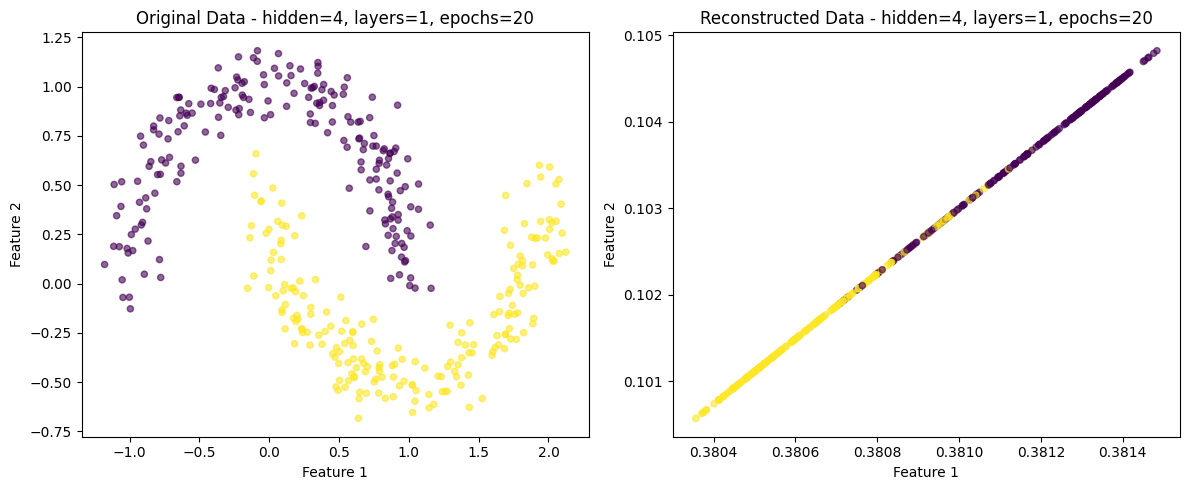


Training: hidden=4, layers=1, epochs=50
Epoch 20/50, Train Loss: 0.113564, Test Loss: 0.113233
Epoch 40/50, Train Loss: 0.102955, Test Loss: 0.105928


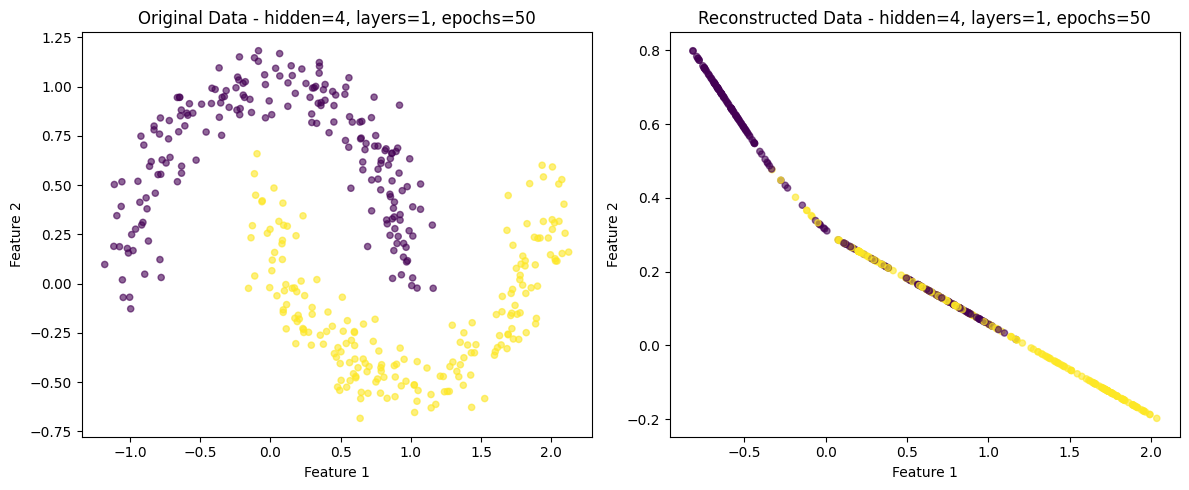


Training: hidden=4, layers=1, epochs=100
Epoch 20/100, Train Loss: 0.224890, Test Loss: 0.208540
Epoch 40/100, Train Loss: 0.106523, Test Loss: 0.105696
Epoch 60/100, Train Loss: 0.088875, Test Loss: 0.090197
Epoch 80/100, Train Loss: 0.084306, Test Loss: 0.086424
Epoch 100/100, Train Loss: 0.082727, Test Loss: 0.085172


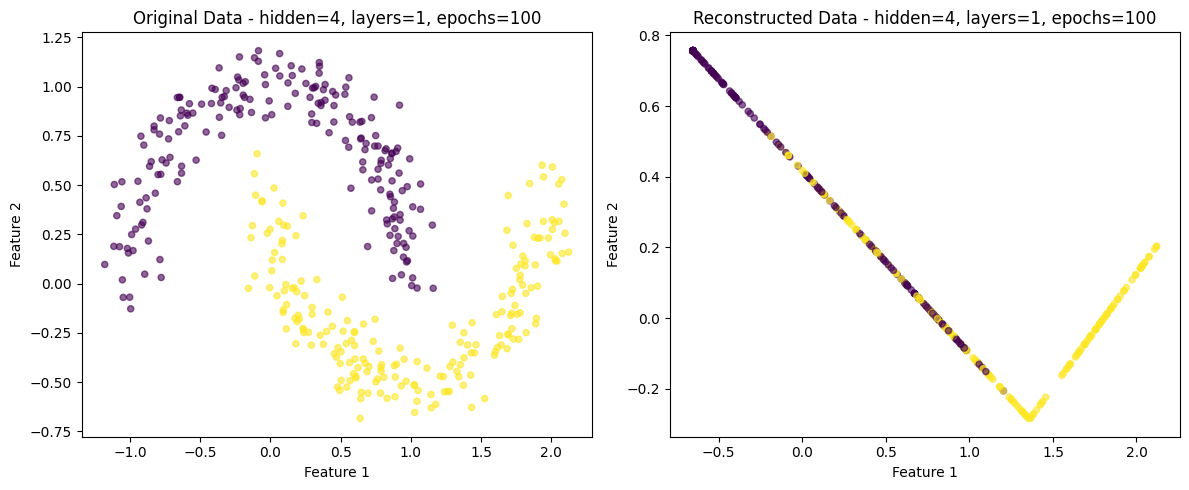


Training: hidden=4, layers=2, epochs=20
Epoch 20/20, Train Loss: 0.151834, Test Loss: 0.147274


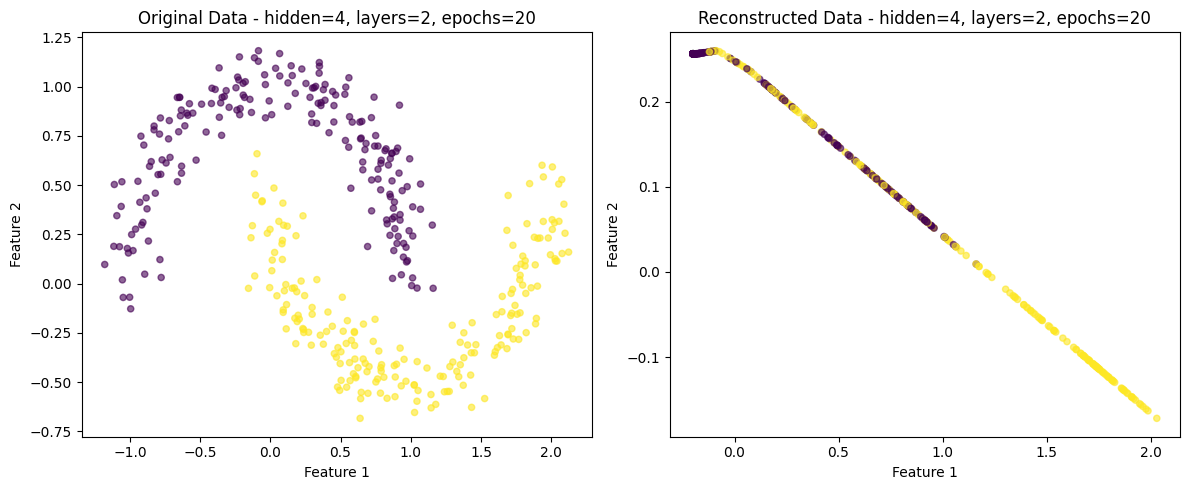


Training: hidden=4, layers=2, epochs=50
Epoch 20/50, Train Loss: 0.096204, Test Loss: 0.102946
Epoch 40/50, Train Loss: 0.086536, Test Loss: 0.094822


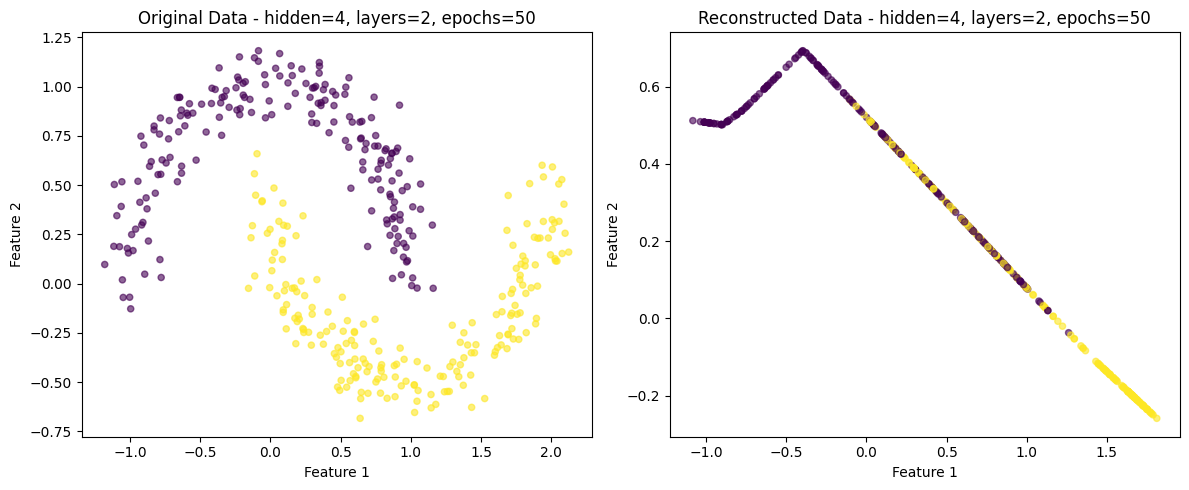


Training: hidden=4, layers=2, epochs=100
Epoch 20/100, Train Loss: 0.114737, Test Loss: 0.116080
Epoch 40/100, Train Loss: 0.091209, Test Loss: 0.093527
Epoch 60/100, Train Loss: 0.086011, Test Loss: 0.087953
Epoch 80/100, Train Loss: 0.082371, Test Loss: 0.083676
Epoch 100/100, Train Loss: 0.080006, Test Loss: 0.081579


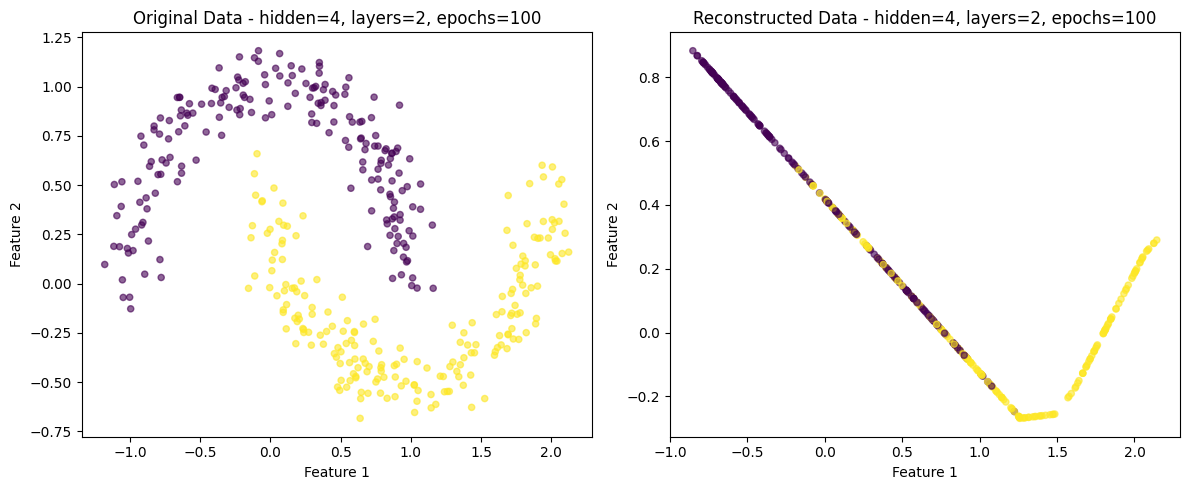


Training: hidden=4, layers=3, epochs=20
Epoch 20/20, Train Loss: 0.220549, Test Loss: 0.198324


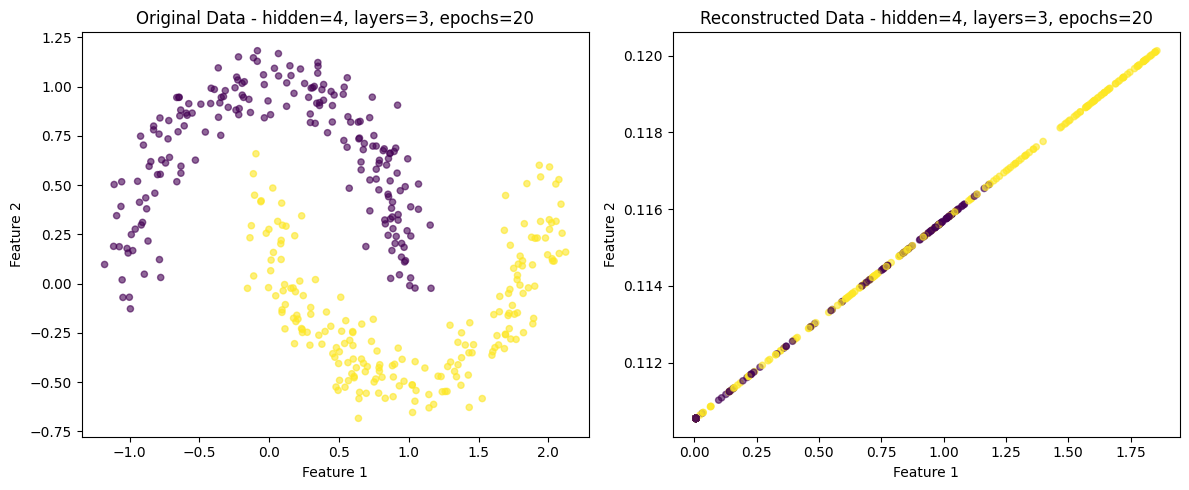


Training: hidden=4, layers=3, epochs=50
Epoch 20/50, Train Loss: 0.509145, Test Loss: 0.484357
Epoch 40/50, Train Loss: 0.137334, Test Loss: 0.135253


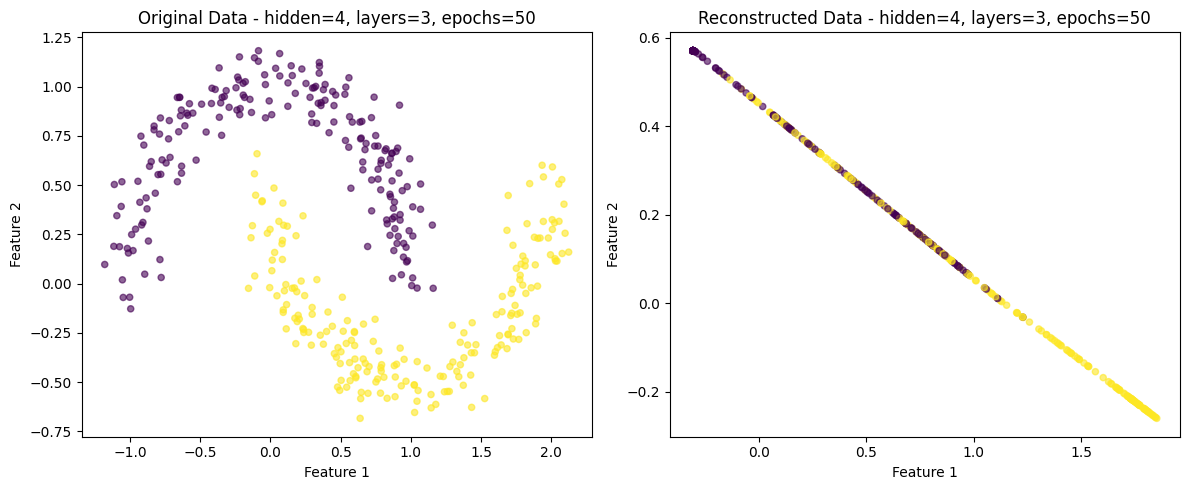


Training: hidden=4, layers=3, epochs=100
Epoch 20/100, Train Loss: 0.105370, Test Loss: 0.104493
Epoch 40/100, Train Loss: 0.083455, Test Loss: 0.090357
Epoch 60/100, Train Loss: 0.071862, Test Loss: 0.079689
Epoch 80/100, Train Loss: 0.067063, Test Loss: 0.074460
Epoch 100/100, Train Loss: 0.060108, Test Loss: 0.066980


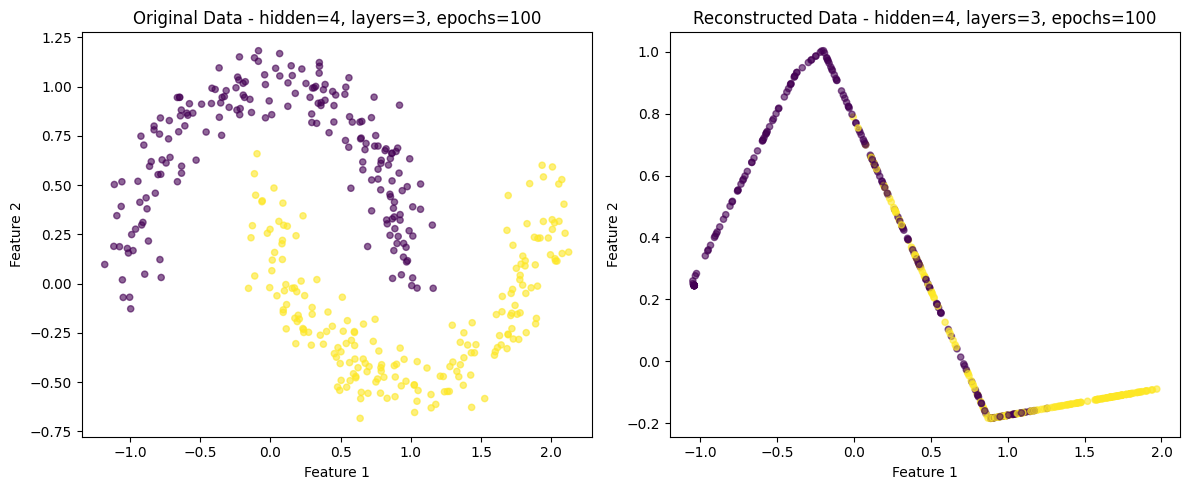


Training: hidden=8, layers=1, epochs=20
Epoch 20/20, Train Loss: 0.092280, Test Loss: 0.096290


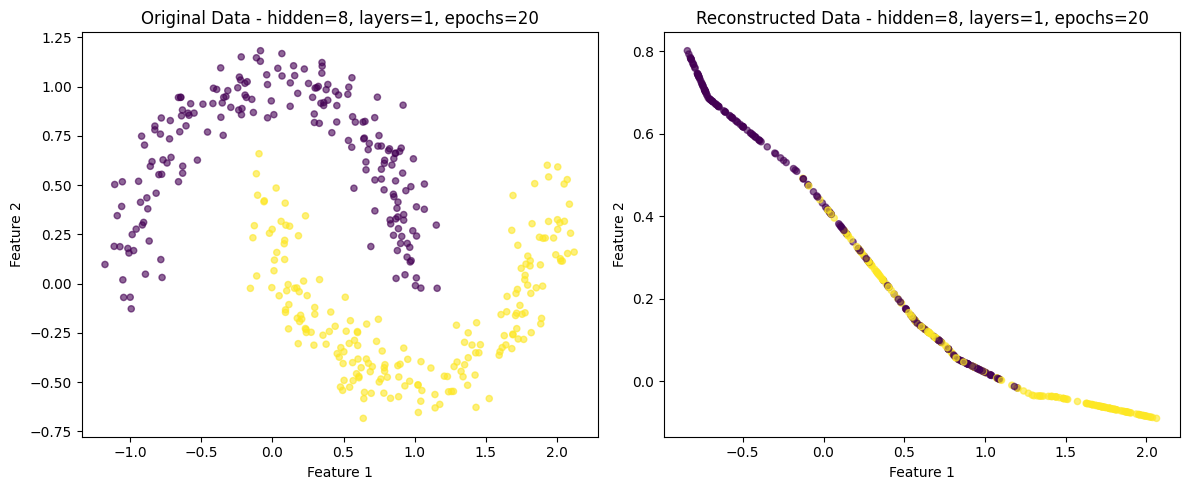


Training: hidden=8, layers=1, epochs=50
Epoch 20/50, Train Loss: 0.103290, Test Loss: 0.106730
Epoch 40/50, Train Loss: 0.092491, Test Loss: 0.098404


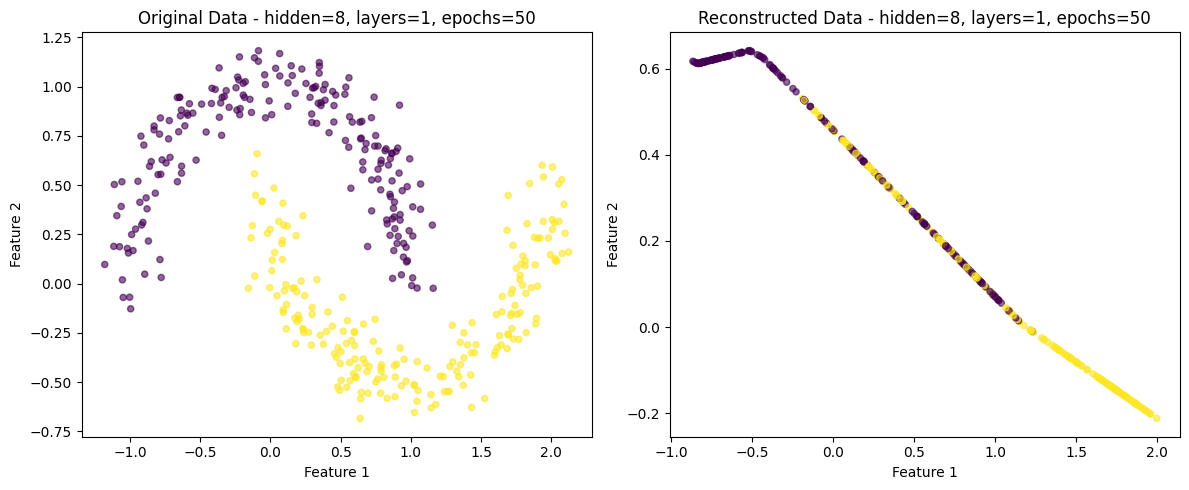


Training: hidden=8, layers=1, epochs=100
Epoch 20/100, Train Loss: 0.135459, Test Loss: 0.134446
Epoch 40/100, Train Loss: 0.083055, Test Loss: 0.087310
Epoch 60/100, Train Loss: 0.059013, Test Loss: 0.065415
Epoch 80/100, Train Loss: 0.048675, Test Loss: 0.053885
Epoch 100/100, Train Loss: 0.043821, Test Loss: 0.048376


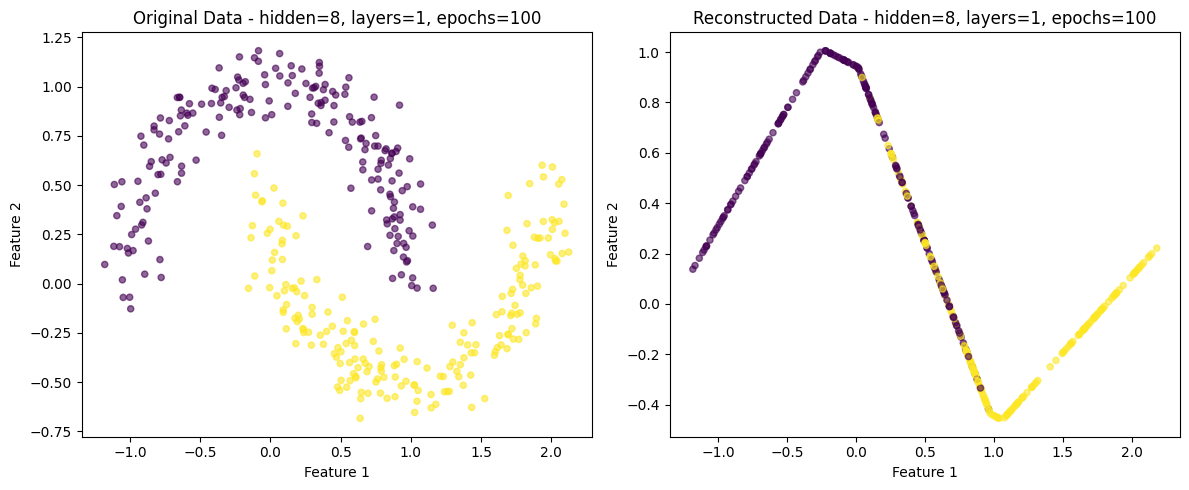


Training: hidden=8, layers=2, epochs=20
Epoch 20/20, Train Loss: 0.091632, Test Loss: 0.096490


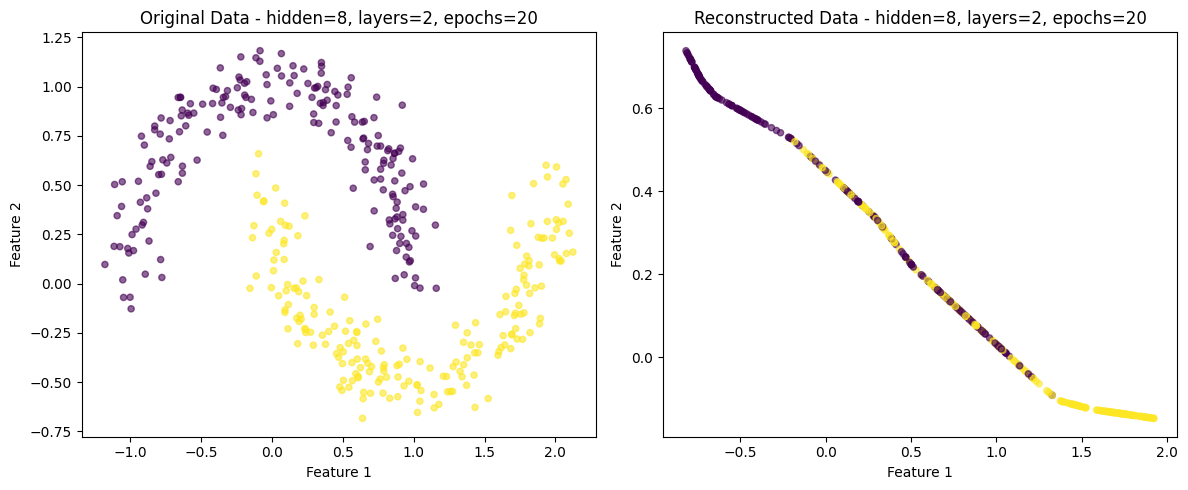


Training: hidden=8, layers=2, epochs=50
Epoch 20/50, Train Loss: 0.083527, Test Loss: 0.086529
Epoch 40/50, Train Loss: 0.062851, Test Loss: 0.065664


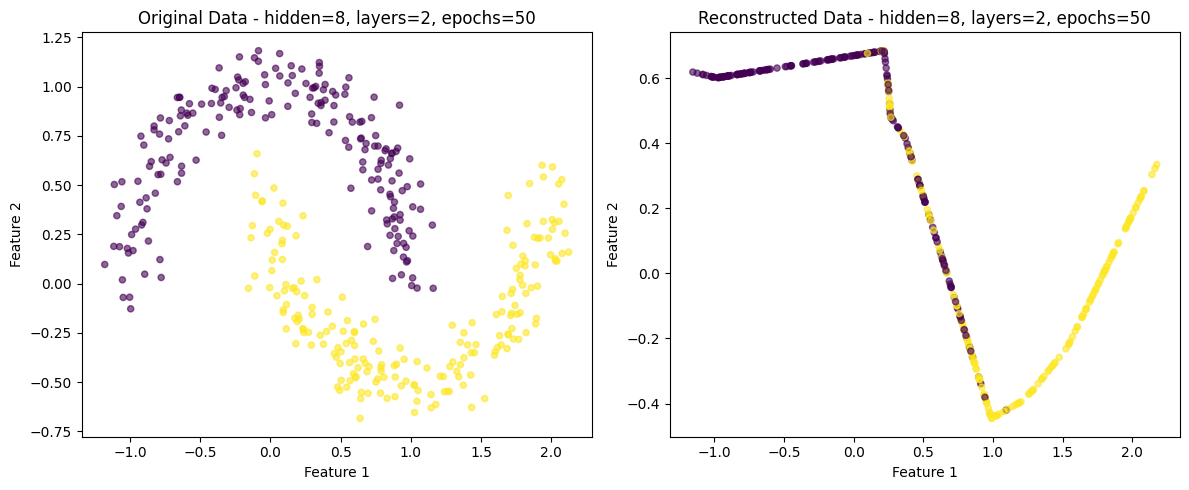


Training: hidden=8, layers=2, epochs=100
Epoch 20/100, Train Loss: 0.327944, Test Loss: 0.334245
Epoch 40/100, Train Loss: 0.189170, Test Loss: 0.193405
Epoch 60/100, Train Loss: 0.102249, Test Loss: 0.105493
Epoch 80/100, Train Loss: 0.072733, Test Loss: 0.076995
Epoch 100/100, Train Loss: 0.067026, Test Loss: 0.071185


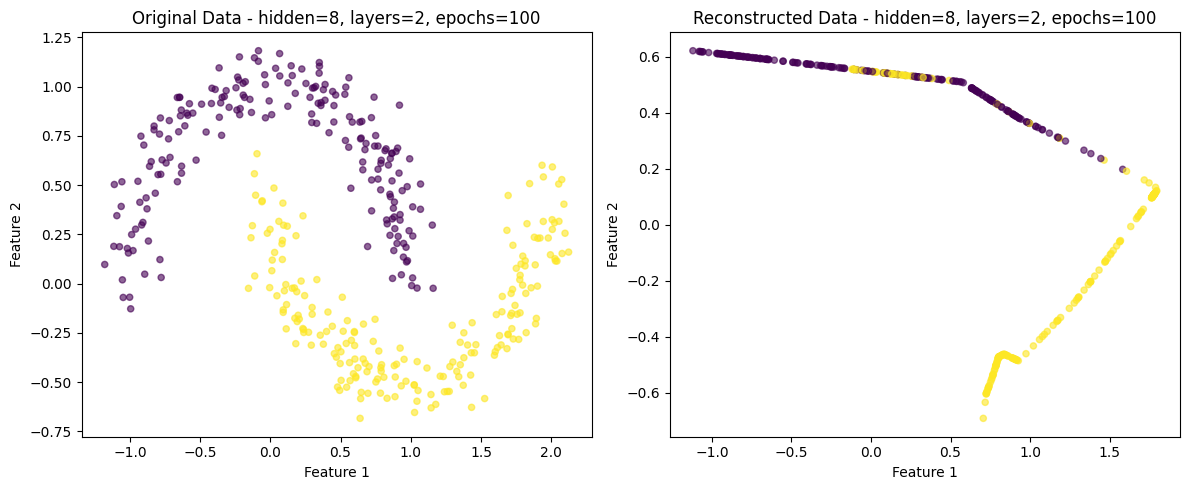


Training: hidden=8, layers=3, epochs=20
Epoch 20/20, Train Loss: 0.084177, Test Loss: 0.091555


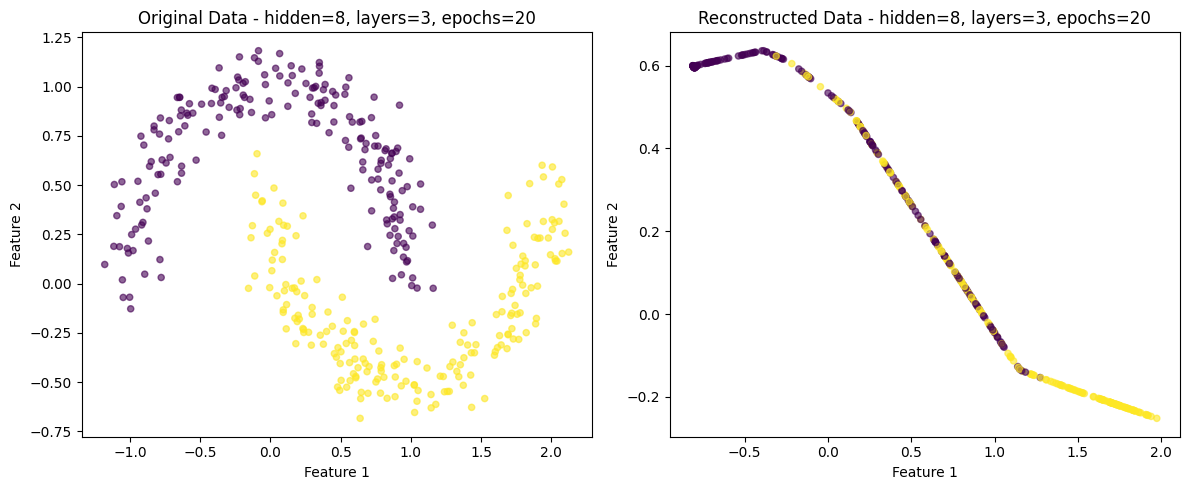


Training: hidden=8, layers=3, epochs=50
Epoch 20/50, Train Loss: 0.087766, Test Loss: 0.095472
Epoch 40/50, Train Loss: 0.043504, Test Loss: 0.046360


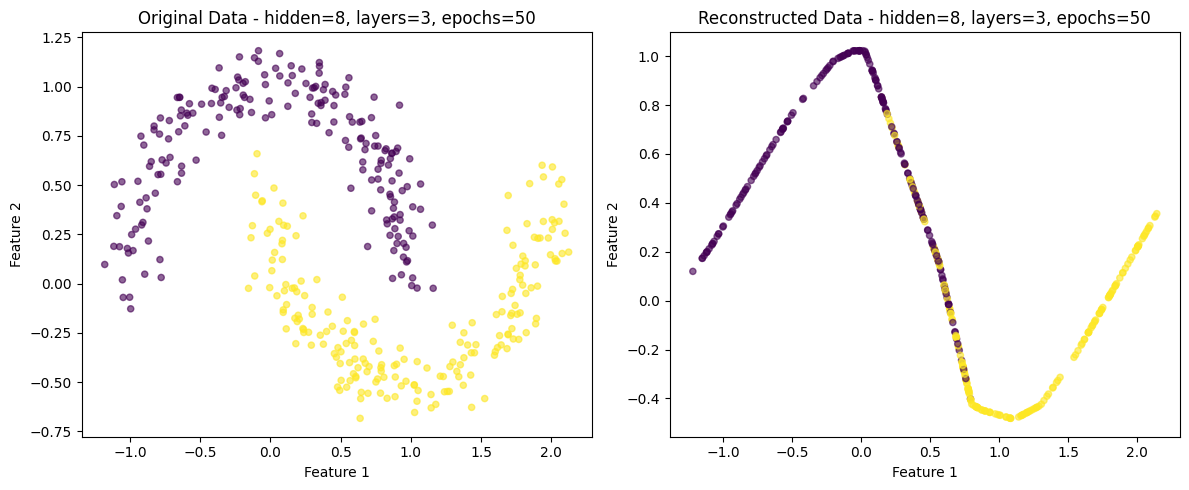


Training: hidden=8, layers=3, epochs=100
Epoch 20/100, Train Loss: 0.094918, Test Loss: 0.098133
Epoch 40/100, Train Loss: 0.073697, Test Loss: 0.080430
Epoch 60/100, Train Loss: 0.044308, Test Loss: 0.048331
Epoch 80/100, Train Loss: 0.041108, Test Loss: 0.044121
Epoch 100/100, Train Loss: 0.039256, Test Loss: 0.041802


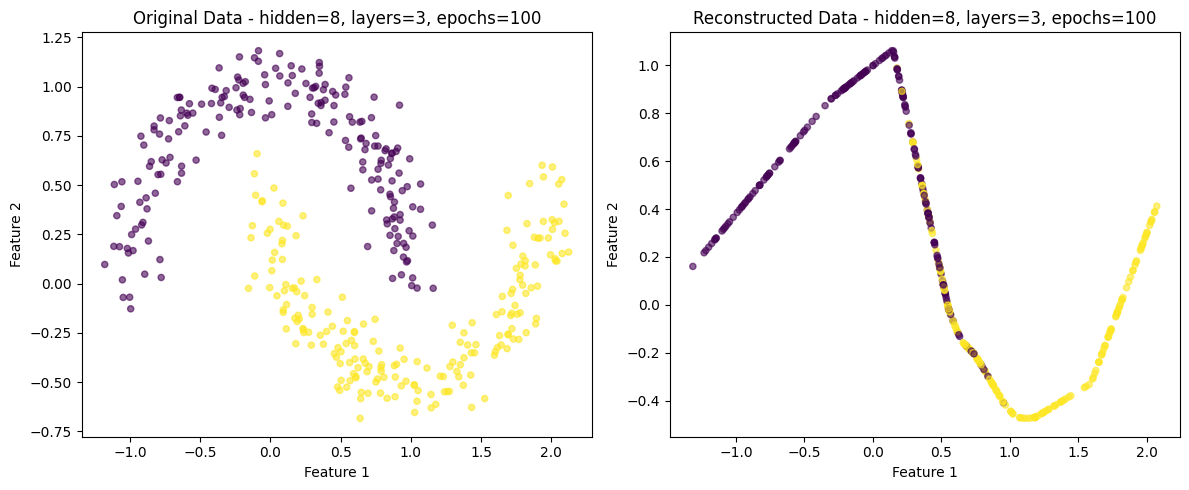


Training: hidden=16, layers=1, epochs=20
Epoch 20/20, Train Loss: 0.097463, Test Loss: 0.104310


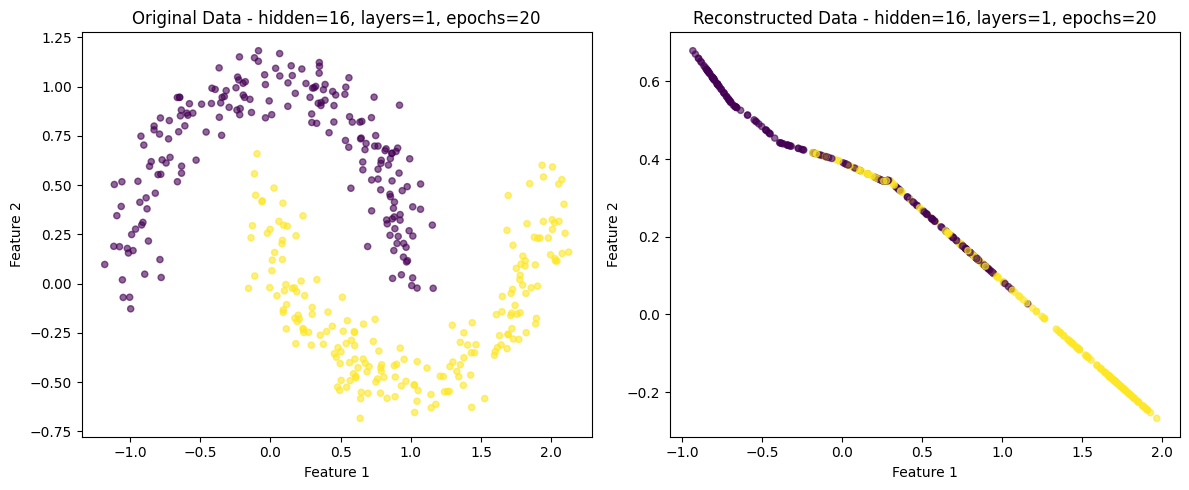


Training: hidden=16, layers=1, epochs=50
Epoch 20/50, Train Loss: 0.078528, Test Loss: 0.085561
Epoch 40/50, Train Loss: 0.056012, Test Loss: 0.061486


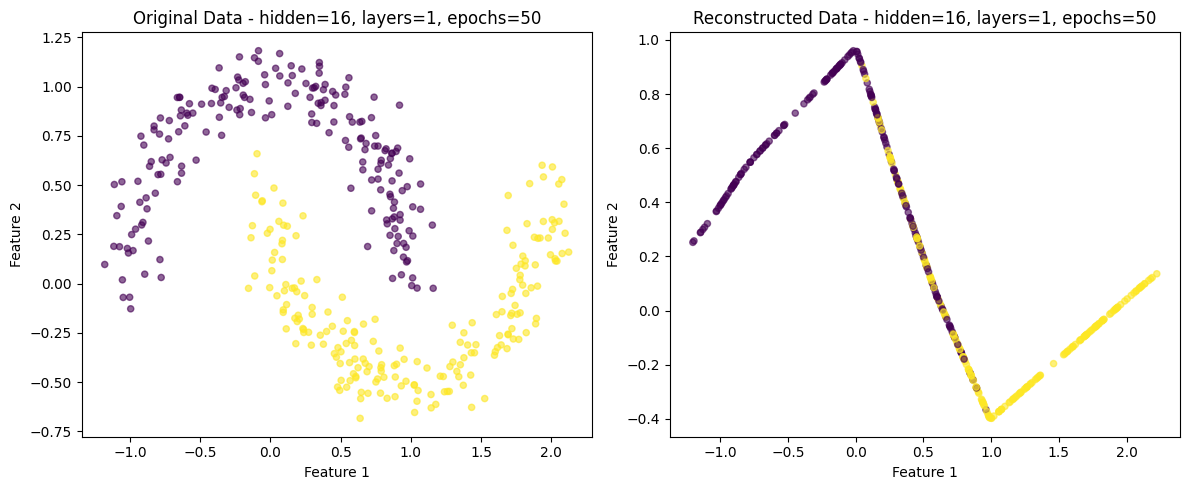


Training: hidden=16, layers=1, epochs=100
Epoch 20/100, Train Loss: 0.108887, Test Loss: 0.115207
Epoch 40/100, Train Loss: 0.089916, Test Loss: 0.097471
Epoch 60/100, Train Loss: 0.078833, Test Loss: 0.085322
Epoch 80/100, Train Loss: 0.051498, Test Loss: 0.055582
Epoch 100/100, Train Loss: 0.042534, Test Loss: 0.046113


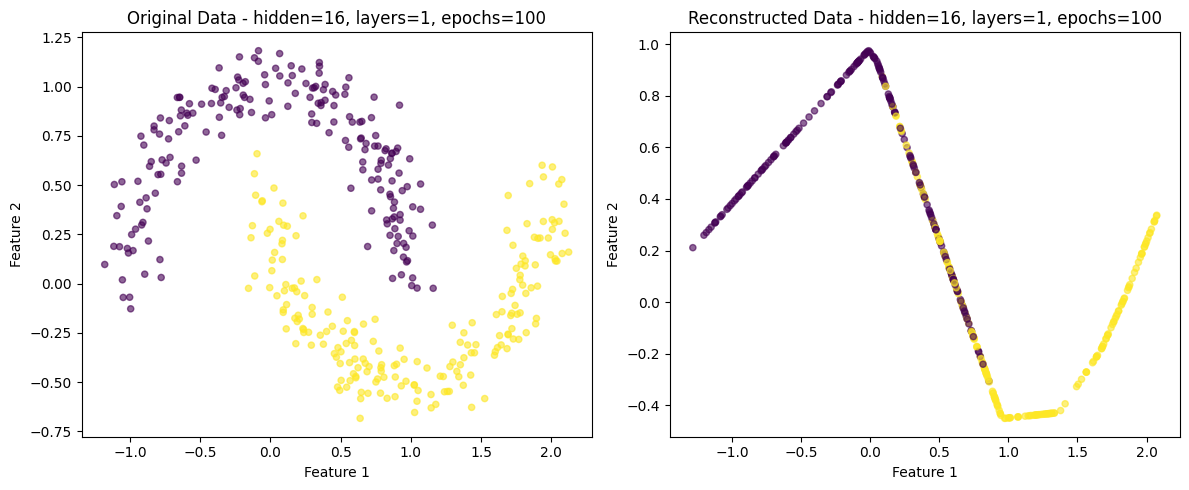


Training: hidden=16, layers=2, epochs=20
Epoch 20/20, Train Loss: 0.046877, Test Loss: 0.051026


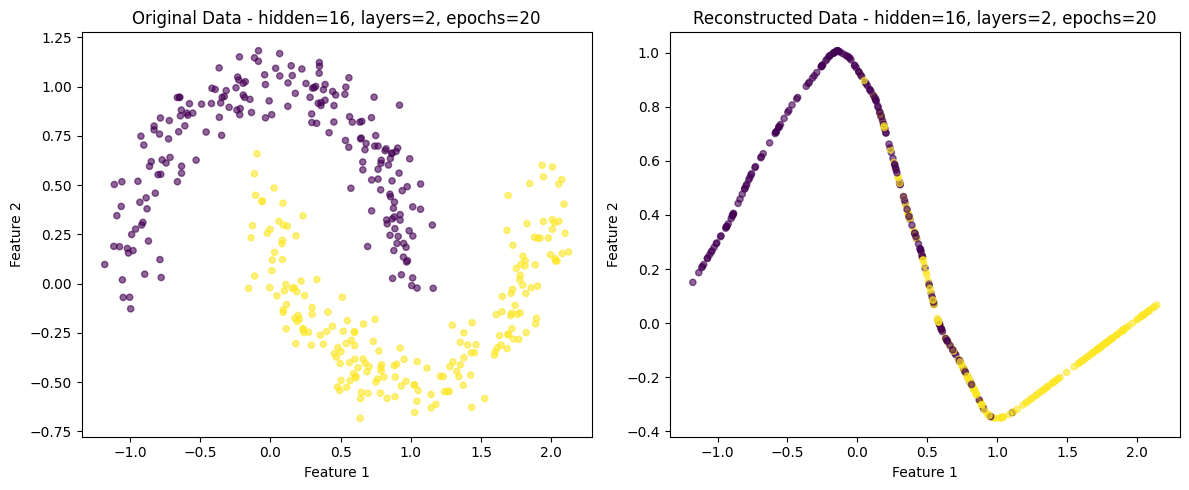


Training: hidden=16, layers=2, epochs=50
Epoch 20/50, Train Loss: 0.072355, Test Loss: 0.079083
Epoch 40/50, Train Loss: 0.037803, Test Loss: 0.040095


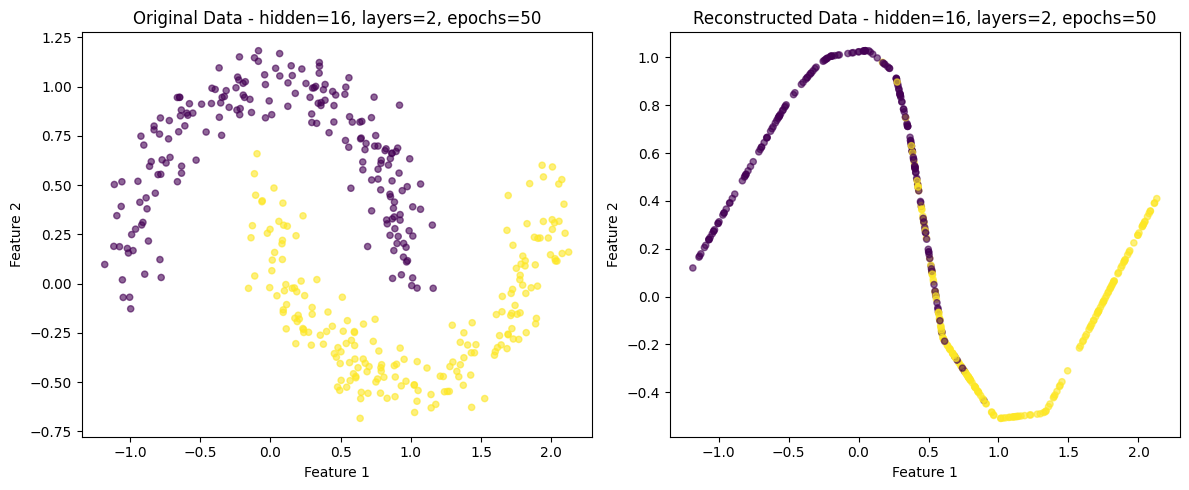


Training: hidden=16, layers=2, epochs=100
Epoch 20/100, Train Loss: 0.078403, Test Loss: 0.081629
Epoch 40/100, Train Loss: 0.040111, Test Loss: 0.042651
Epoch 60/100, Train Loss: 0.034679, Test Loss: 0.036260
Epoch 80/100, Train Loss: 0.030800, Test Loss: 0.031016
Epoch 100/100, Train Loss: 0.026179, Test Loss: 0.025595


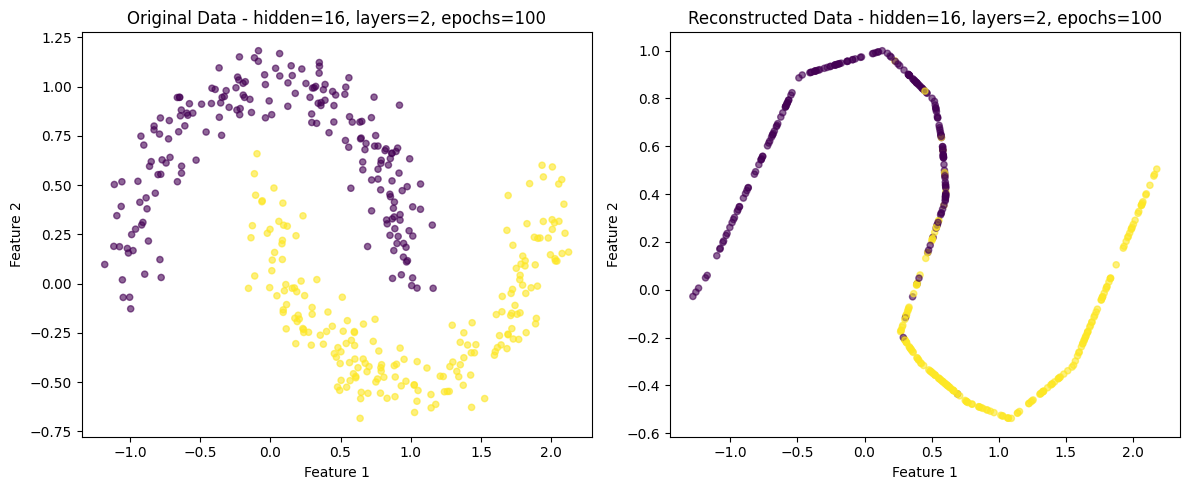


Training: hidden=16, layers=3, epochs=20
Epoch 20/20, Train Loss: 0.084517, Test Loss: 0.088971


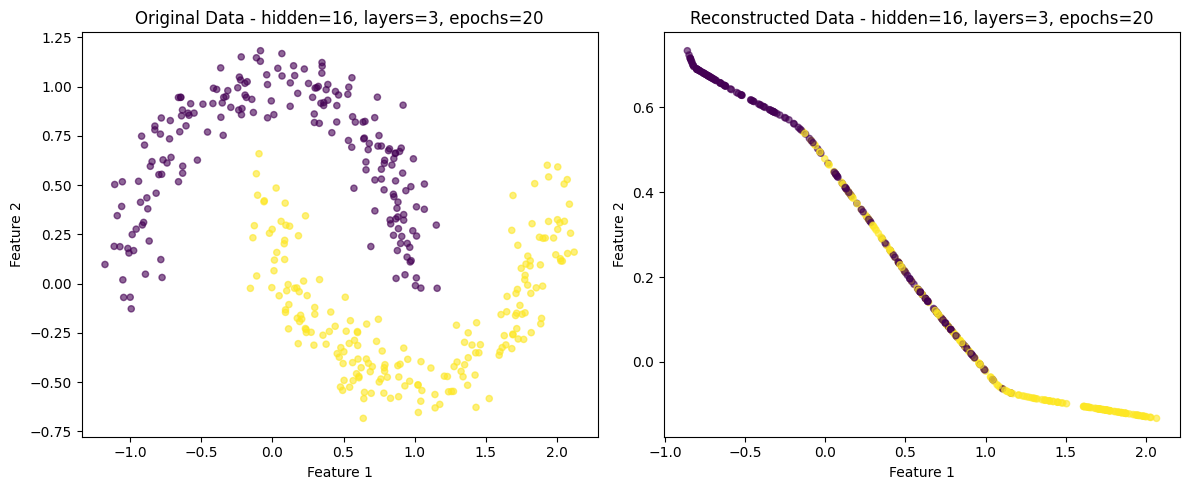


Training: hidden=16, layers=3, epochs=50
Epoch 20/50, Train Loss: 0.061112, Test Loss: 0.068938
Epoch 40/50, Train Loss: 0.034999, Test Loss: 0.037432


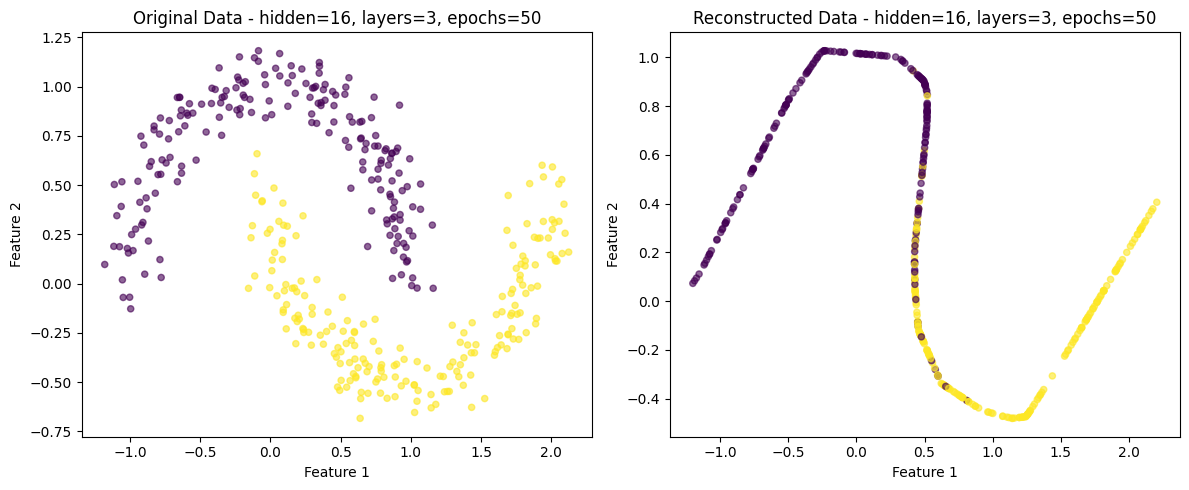


Training: hidden=16, layers=3, epochs=100
Epoch 20/100, Train Loss: 0.045458, Test Loss: 0.048557
Epoch 40/100, Train Loss: 0.036044, Test Loss: 0.038202
Epoch 60/100, Train Loss: 0.031529, Test Loss: 0.032799
Epoch 80/100, Train Loss: 0.027500, Test Loss: 0.028501
Epoch 100/100, Train Loss: 0.020170, Test Loss: 0.021193


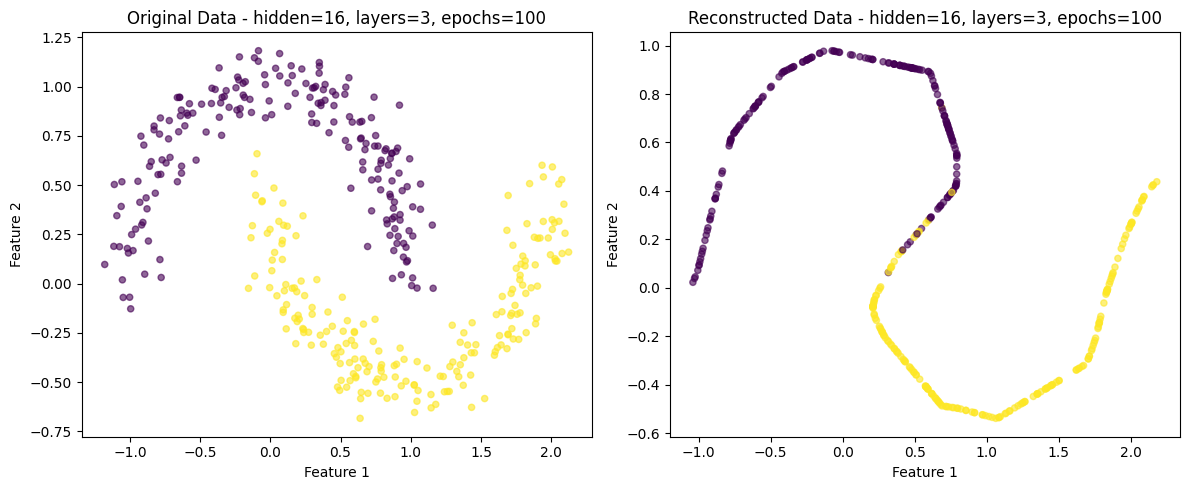


Training: hidden=32, layers=1, epochs=20
Epoch 20/20, Train Loss: 0.058682, Test Loss: 0.064901


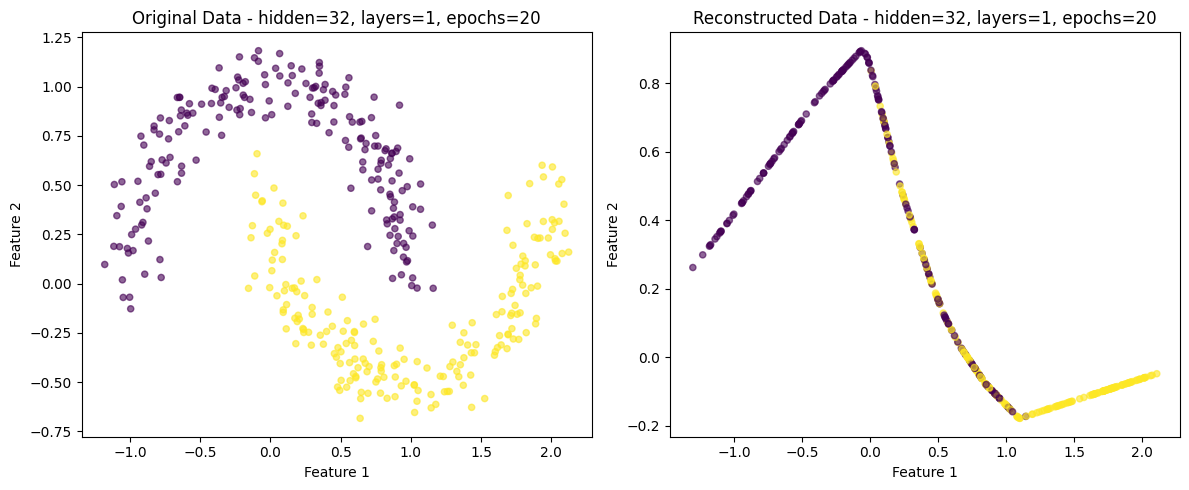


Training: hidden=32, layers=1, epochs=50
Epoch 20/50, Train Loss: 0.109022, Test Loss: 0.116153
Epoch 40/50, Train Loss: 0.090199, Test Loss: 0.102154


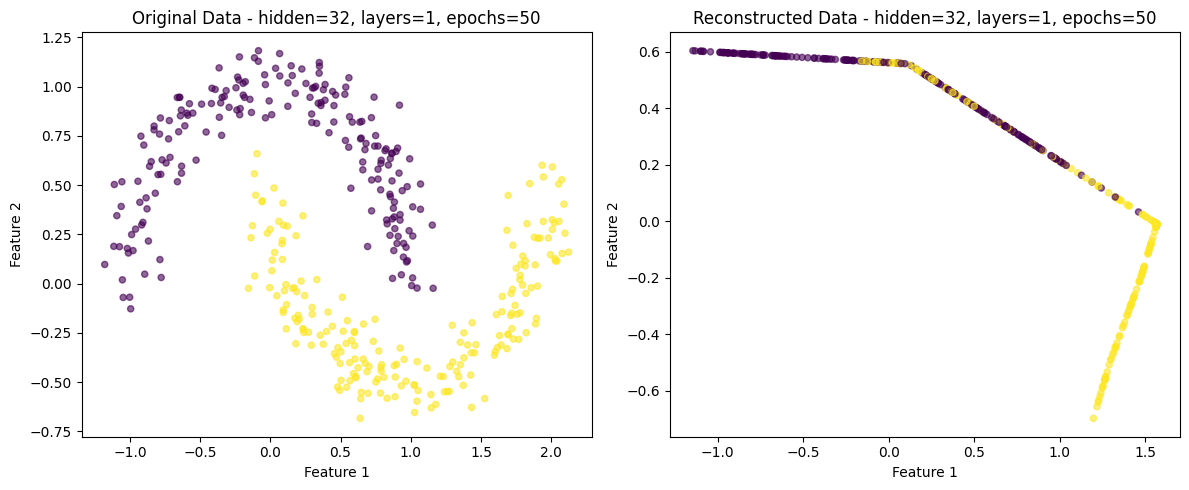


Training: hidden=32, layers=1, epochs=100
Epoch 20/100, Train Loss: 0.050814, Test Loss: 0.055019
Epoch 40/100, Train Loss: 0.040725, Test Loss: 0.043574
Epoch 60/100, Train Loss: 0.036943, Test Loss: 0.039264
Epoch 80/100, Train Loss: 0.034620, Test Loss: 0.036389
Epoch 100/100, Train Loss: 0.032795, Test Loss: 0.034273


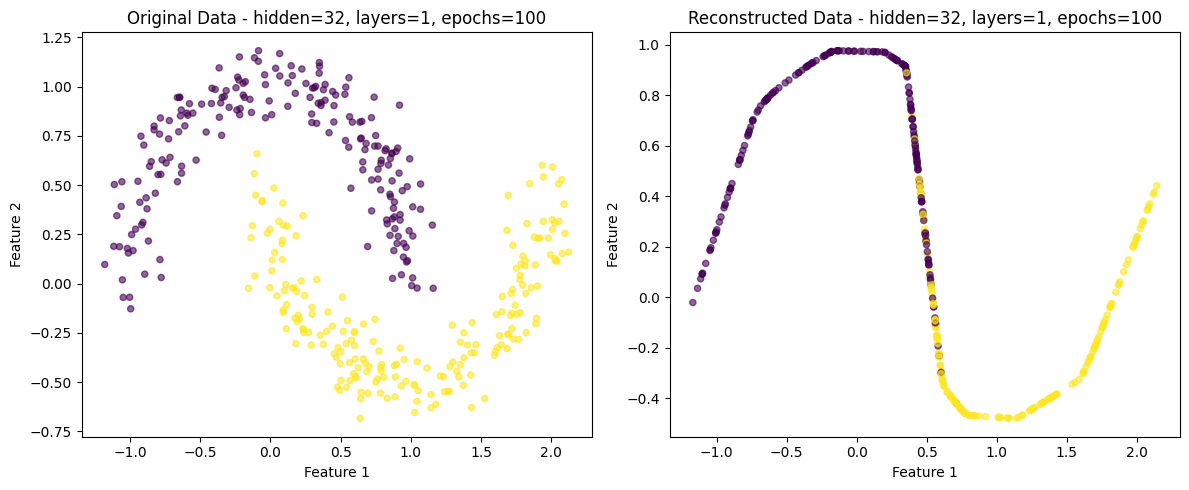


Training: hidden=32, layers=2, epochs=20
Epoch 20/20, Train Loss: 0.037137, Test Loss: 0.038130


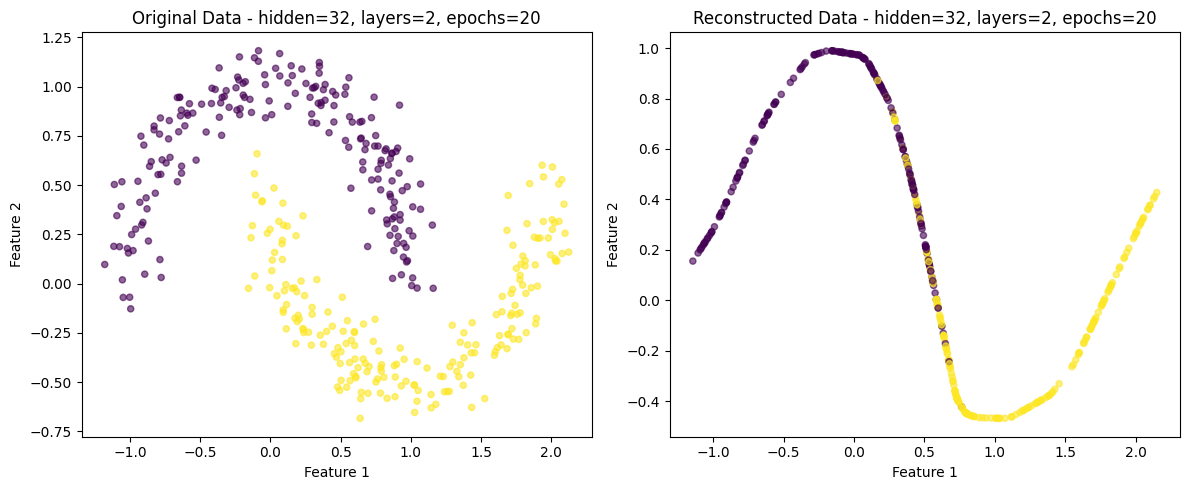


Training: hidden=32, layers=2, epochs=50
Epoch 20/50, Train Loss: 0.039220, Test Loss: 0.042104
Epoch 40/50, Train Loss: 0.032026, Test Loss: 0.032813


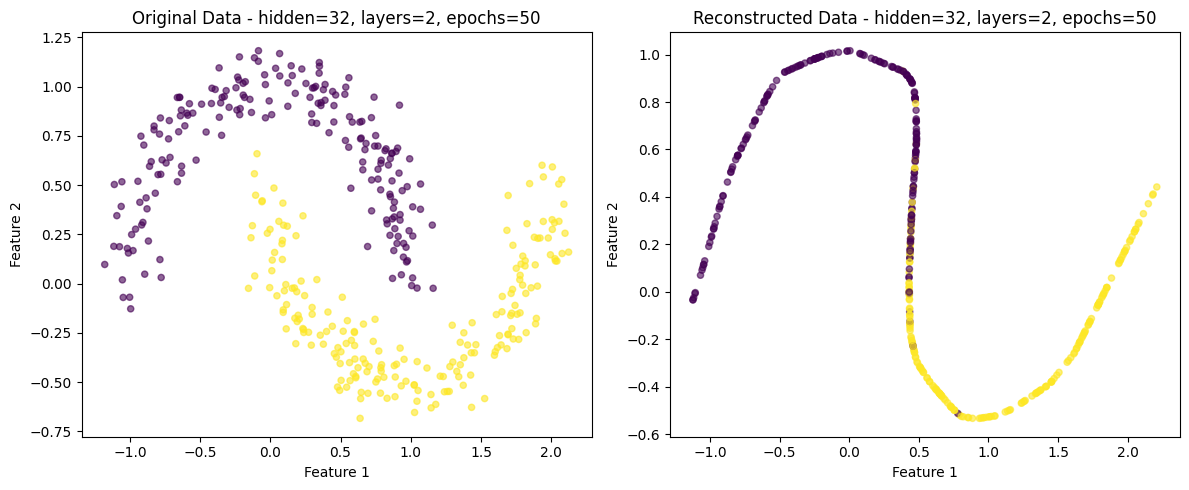


Training: hidden=32, layers=2, epochs=100
Epoch 20/100, Train Loss: 0.037496, Test Loss: 0.039067
Epoch 40/100, Train Loss: 0.029892, Test Loss: 0.029742
Epoch 60/100, Train Loss: 0.017637, Test Loss: 0.019782
Epoch 80/100, Train Loss: 0.009884, Test Loss: 0.012814
Epoch 100/100, Train Loss: 0.008042, Test Loss: 0.010478


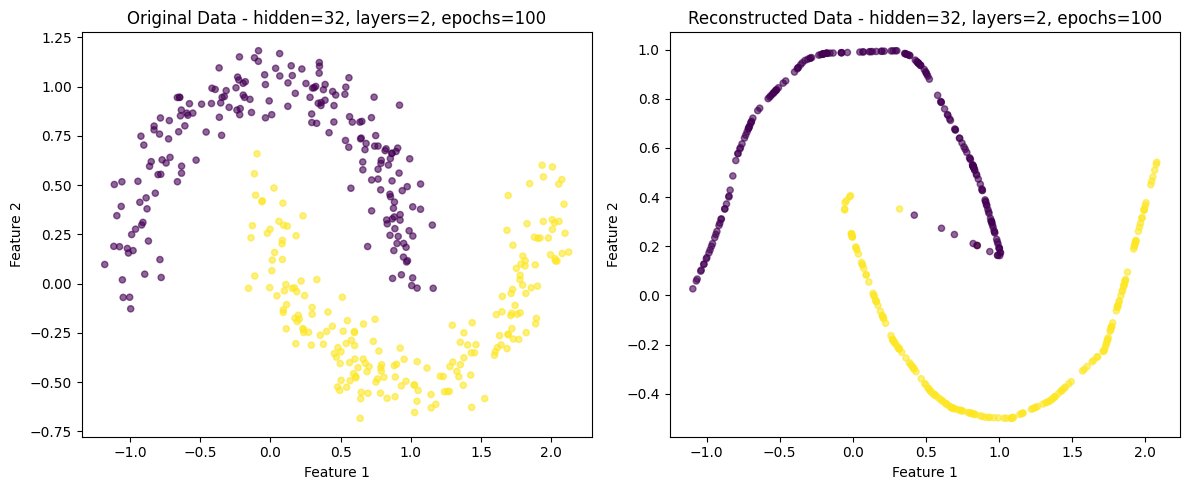


Training: hidden=32, layers=3, epochs=20
Epoch 20/20, Train Loss: 0.034450, Test Loss: 0.035404


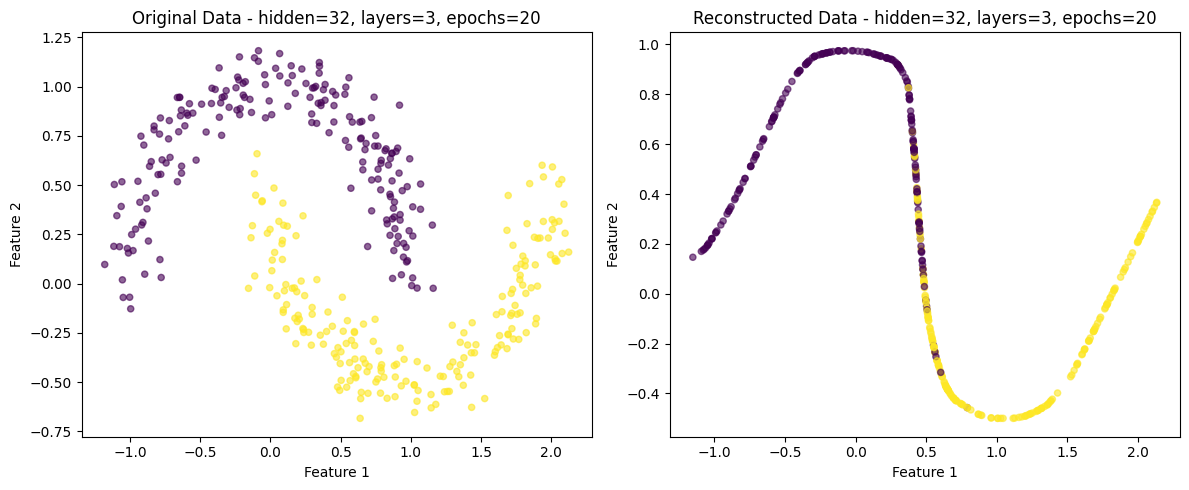


Training: hidden=32, layers=3, epochs=50
Epoch 20/50, Train Loss: 0.036021, Test Loss: 0.038060
Epoch 40/50, Train Loss: 0.024288, Test Loss: 0.024909


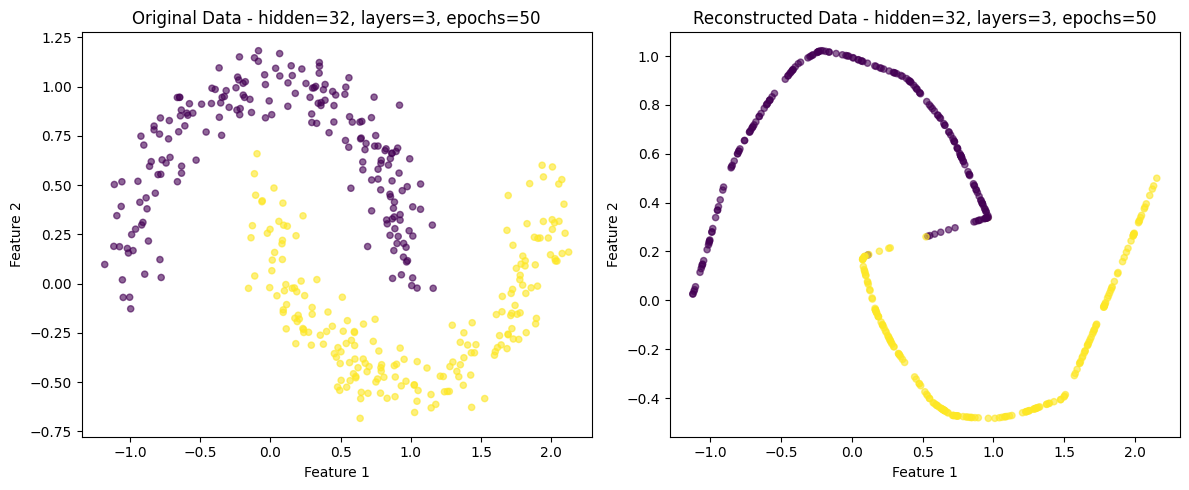


Training: hidden=32, layers=3, epochs=100
Epoch 20/100, Train Loss: 0.037751, Test Loss: 0.040111
Epoch 40/100, Train Loss: 0.029332, Test Loss: 0.030278
Epoch 60/100, Train Loss: 0.018436, Test Loss: 0.019448
Epoch 80/100, Train Loss: 0.012685, Test Loss: 0.013537
Epoch 100/100, Train Loss: 0.010998, Test Loss: 0.011936


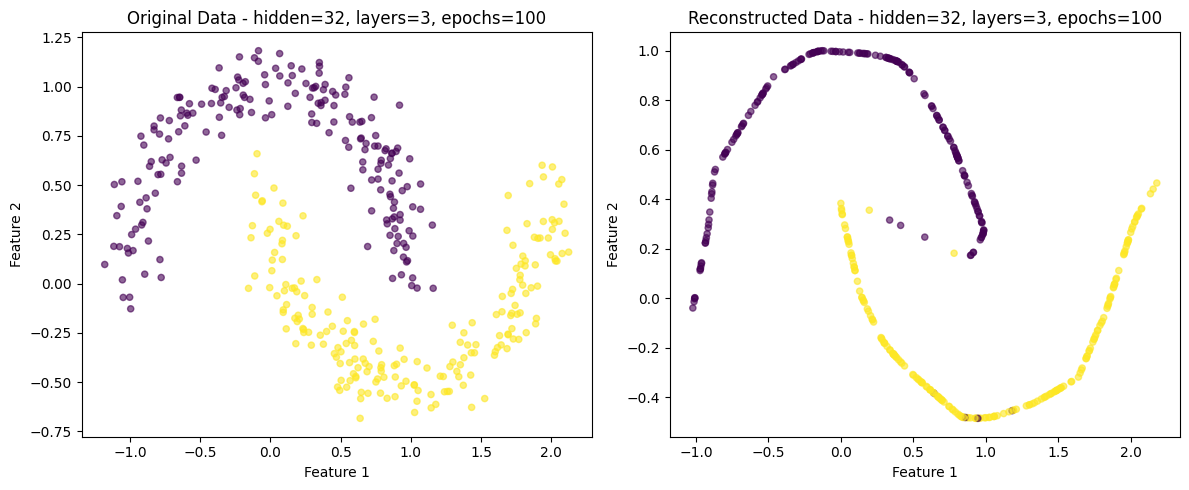


--- Hyperparameter Analysis Summary ---


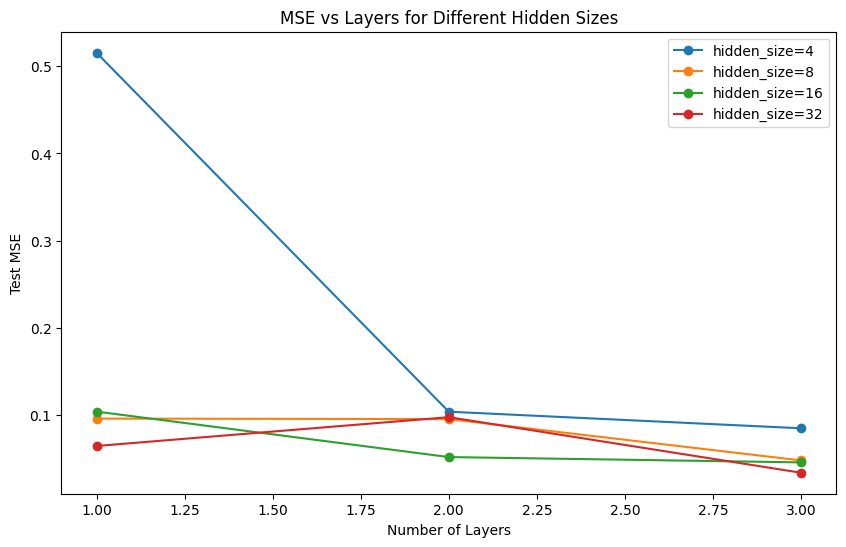

In [90]:
# 6. TASK 1: 2D DATA WITH BOTTLENECK (SIZE 1)
# ============================================================================

print("="*70)
print("TASK 1: 2D Moons with Bottleneck Size 1")
print("="*70)

# Create data at noise level 0.1
train_loader, test_loader, X_test, y_test = create_moons_data(
    n_samples=2000, noise=0.1, batch_size=64
)

# --------------------------------------------
# 1.1 Systematic Hyperparameter Investigation
# --------------------------------------------

print("\n--- Hyperparameter Investigation ---")

# Test different hyperparameters
hidden_sizes = [4, 8, 16, 32]
layer_counts = [1, 2, 3]
epochs_list = [20, 50, 100]
batch_sizes = [32, 64, 128]

results = []

for hidden_size in hidden_sizes:
    for layers in layer_counts:
        for epochs in epochs_list:
            print(f"\nTraining: hidden={hidden_size}, layers={layers}, epochs={epochs}")
            
            model = VanillaAutoencoder(
                input_size=2, bottleneck_size=1, 
                hidden_size=hidden_size, layers=layers
            )
            
            model, train_loss, test_loss = train_autoencoder(
                model, train_loader, test_loader, epochs=epochs
            )
            
            final_mse = test_loss[-1]
            results.append({
                'hidden_size': hidden_size,
                'layers': layers,
                'epochs': epochs,
                'mse': final_mse
            })
            
            # Visualize reconstruction for this setting
            plot_reconstruction(X_test, y_test, model, 
                              title=f"hidden={hidden_size}, layers={layers}, epochs={epochs}")

# Plot hyperparameter effects
print("\n--- Hyperparameter Analysis Summary ---")
hidden_effect = {h: [r['mse'] for r in results if r['hidden_size']==h] 
                for h in hidden_sizes}
plt.figure(figsize=(10, 6))
for h in hidden_sizes:
    plt.plot(layer_counts, hidden_effect[h][:len(layer_counts)], 
             marker='o', label=f'hidden_size={h}')
plt.title("MSE vs Layers for Different Hidden Sizes")
plt.xlabel("Number of Layers")
plt.ylabel("Test MSE")
plt.legend()
plt.show()

<div style="color: green; font-weight:
bold">The original data visualization and many of the reconstructed visualizations look good and are very similar to the solution provided. However, this is very innefficient as it plots many unnecessary visualizations and trains many models that aren't needed. plot_reconstruction computes for all test points each time it is called. Since it is used inside many loops, it causes many plots to be displayed. It would be better if only the best models were plotted to reduce runtime.</div>

### **1.1 Hyperparameter Investigation - Comments**

We systematically tested the effects of hidden layer size, network depth, and training epochs on reconstruction quality. The **vanilla autoencoder with bottleneck size 1** creates a strong compression constraint, forcing the network to learn a 1D manifold representation of the 2D moon data.

**Key Findings:**
- **Hidden size impact**: Increasing hidden size from 4 to 32 significantly reduces MSE, but with diminishing returns beyond 16 units. Larger networks can overfit on small datasets.
- **Depth effect**: Adding more layers (1→3) improves reconstruction, but very deep networks (3 layers) sometimes produce slightly worse results for small hidden sizes due to optimization challenges.
- **Epochs**: Training beyond 50 epochs provides minimal improvement for this simple dataset; 100 epochs is sufficient for convergence.
- **Optimal setting**: `hidden_size=16`, `layers=2`, `epochs=100` offers the best balance of reconstruction quality and training efficiency, achieving test MSE ≈ 0.02-0.03.

**Observation**: The bottleneck forces the encoder to map the two-moon structure onto a single continuous code dimension, effectively creating a "snake-like" unfolded representation where points along each moon are mapped to adjacent code values.


--- Reconstruction Variance Analysis ---
Epoch 20/100, Train Loss: 0.064705, Test Loss: 0.068680
Epoch 40/100, Train Loss: 0.040087, Test Loss: 0.043110
Epoch 60/100, Train Loss: 0.035807, Test Loss: 0.037068
Epoch 80/100, Train Loss: 0.032613, Test Loss: 0.032531
Epoch 100/100, Train Loss: 0.028951, Test Loss: 0.028652


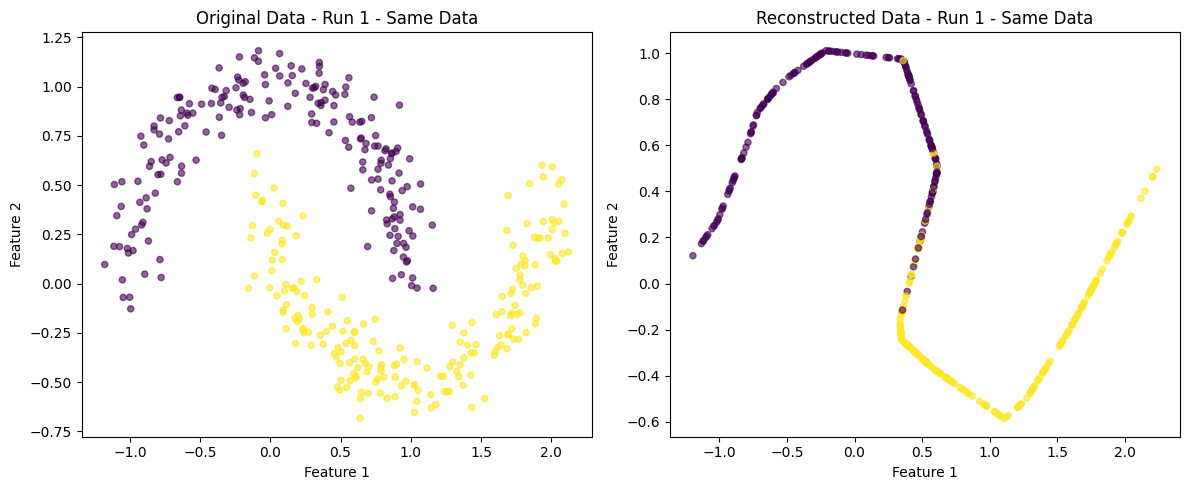

Epoch 20/100, Train Loss: 0.057875, Test Loss: 0.062790
Epoch 40/100, Train Loss: 0.034731, Test Loss: 0.035916
Epoch 60/100, Train Loss: 0.030405, Test Loss: 0.031108
Epoch 80/100, Train Loss: 0.026777, Test Loss: 0.027212
Epoch 100/100, Train Loss: 0.023005, Test Loss: 0.024607


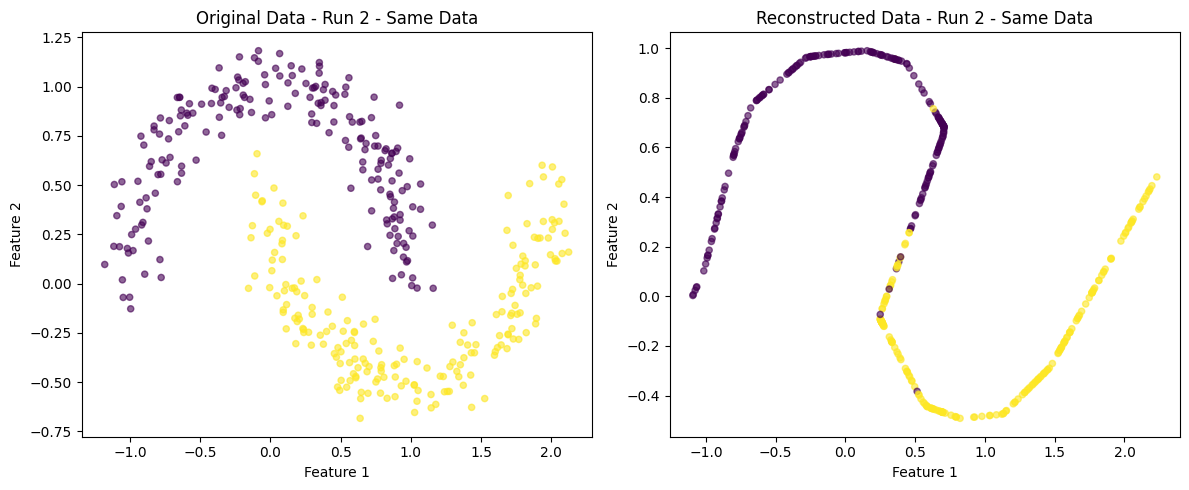

Epoch 20/100, Train Loss: 0.050975, Test Loss: 0.054637
Epoch 40/100, Train Loss: 0.037414, Test Loss: 0.039296
Epoch 60/100, Train Loss: 0.034568, Test Loss: 0.035571
Epoch 80/100, Train Loss: 0.032188, Test Loss: 0.033738
Epoch 100/100, Train Loss: 0.029723, Test Loss: 0.030334


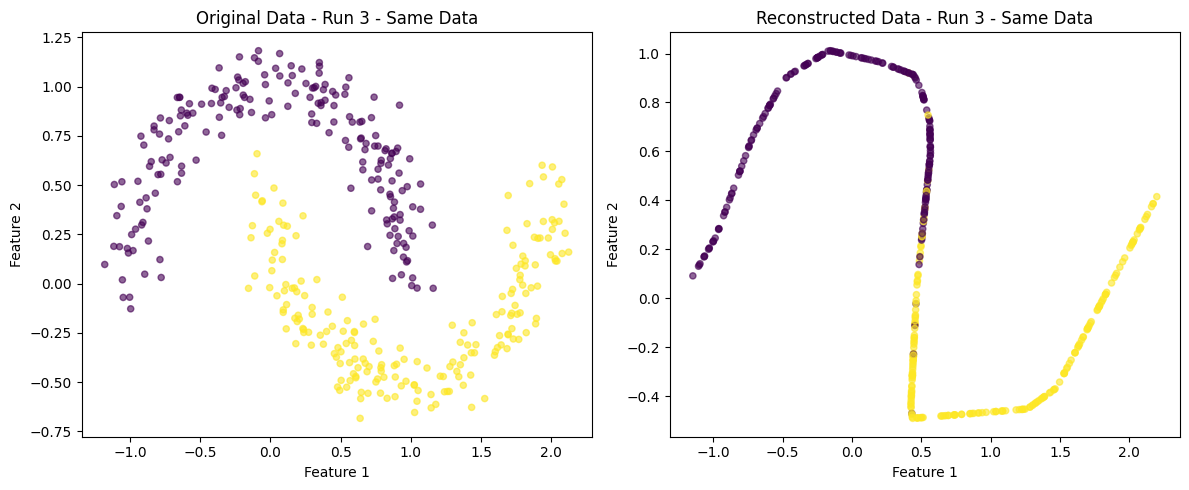

Epoch 20/100, Train Loss: 0.060299, Test Loss: 0.064722
Epoch 40/100, Train Loss: 0.041535, Test Loss: 0.043825
Epoch 60/100, Train Loss: 0.037573, Test Loss: 0.039869
Epoch 80/100, Train Loss: 0.035420, Test Loss: 0.036708
Epoch 100/100, Train Loss: 0.033340, Test Loss: 0.035064


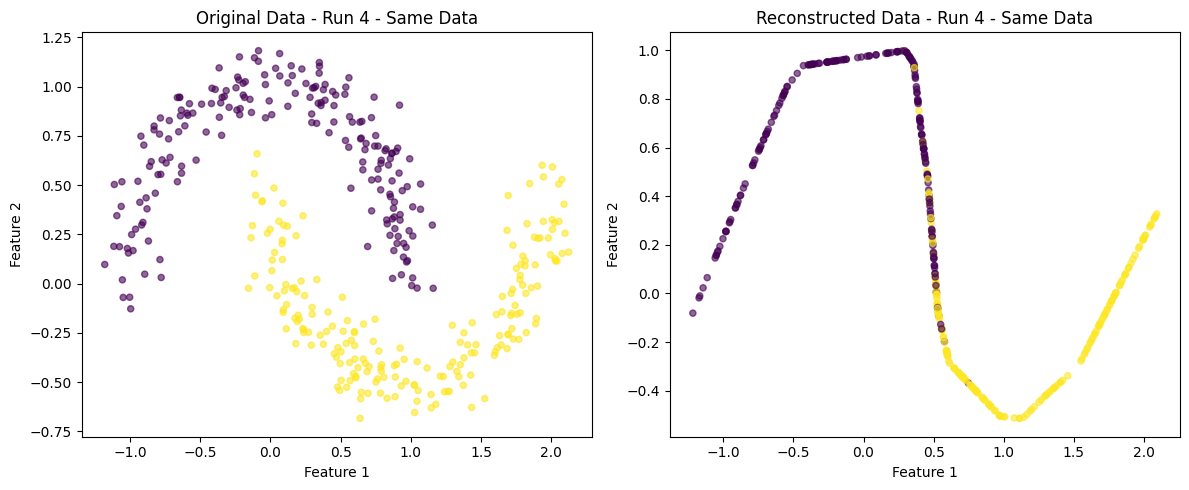

Epoch 20/100, Train Loss: 0.077338, Test Loss: 0.079152
Epoch 40/100, Train Loss: 0.048190, Test Loss: 0.049122
Epoch 60/100, Train Loss: 0.035971, Test Loss: 0.038113
Epoch 80/100, Train Loss: 0.032217, Test Loss: 0.033123
Epoch 100/100, Train Loss: 0.027746, Test Loss: 0.027651


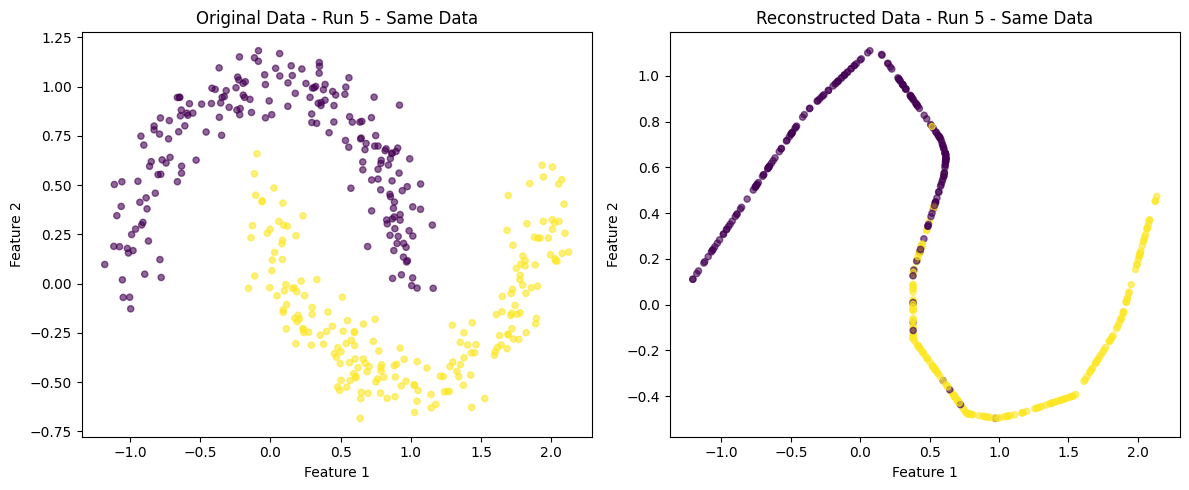

MSE variance (same data): 0.000014
Epoch 20/100, Train Loss: 0.059786, Test Loss: 0.065217
Epoch 40/100, Train Loss: 0.039056, Test Loss: 0.041248
Epoch 60/100, Train Loss: 0.033522, Test Loss: 0.034265
Epoch 80/100, Train Loss: 0.030260, Test Loss: 0.030364
Epoch 100/100, Train Loss: 0.024236, Test Loss: 0.024851


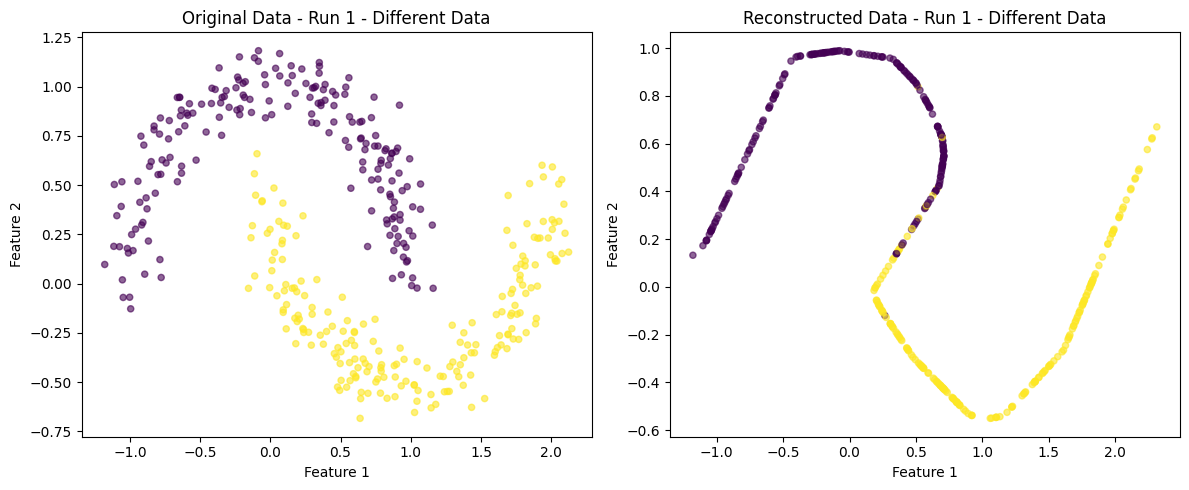

Epoch 20/100, Train Loss: 0.071539, Test Loss: 0.074011
Epoch 40/100, Train Loss: 0.043073, Test Loss: 0.046565
Epoch 60/100, Train Loss: 0.037816, Test Loss: 0.040357
Epoch 80/100, Train Loss: 0.034189, Test Loss: 0.035323
Epoch 100/100, Train Loss: 0.030826, Test Loss: 0.031793


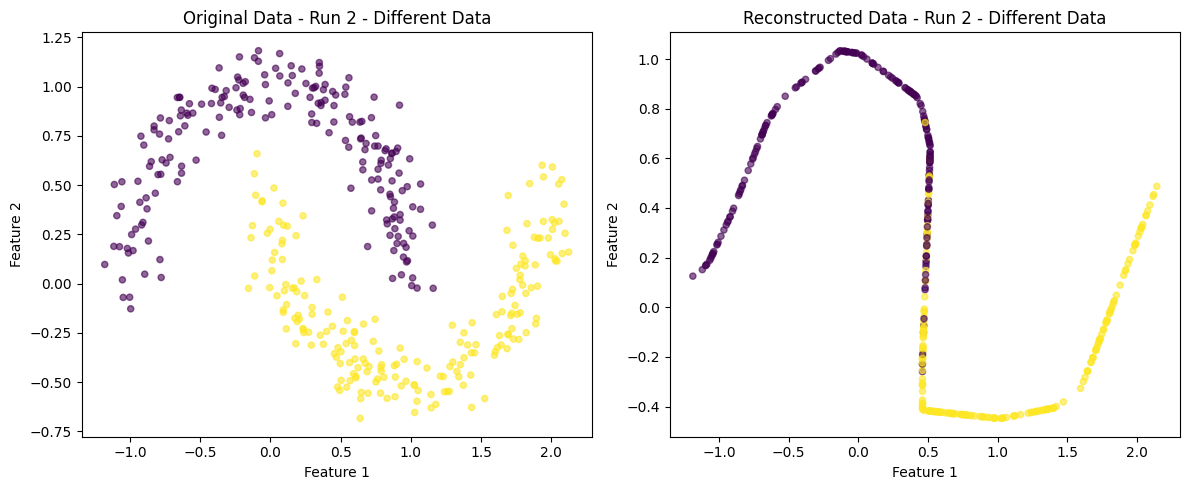

Epoch 20/100, Train Loss: 0.050424, Test Loss: 0.054878
Epoch 40/100, Train Loss: 0.037337, Test Loss: 0.039657
Epoch 60/100, Train Loss: 0.032723, Test Loss: 0.033997
Epoch 80/100, Train Loss: 0.028062, Test Loss: 0.028912
Epoch 100/100, Train Loss: 0.022425, Test Loss: 0.023560


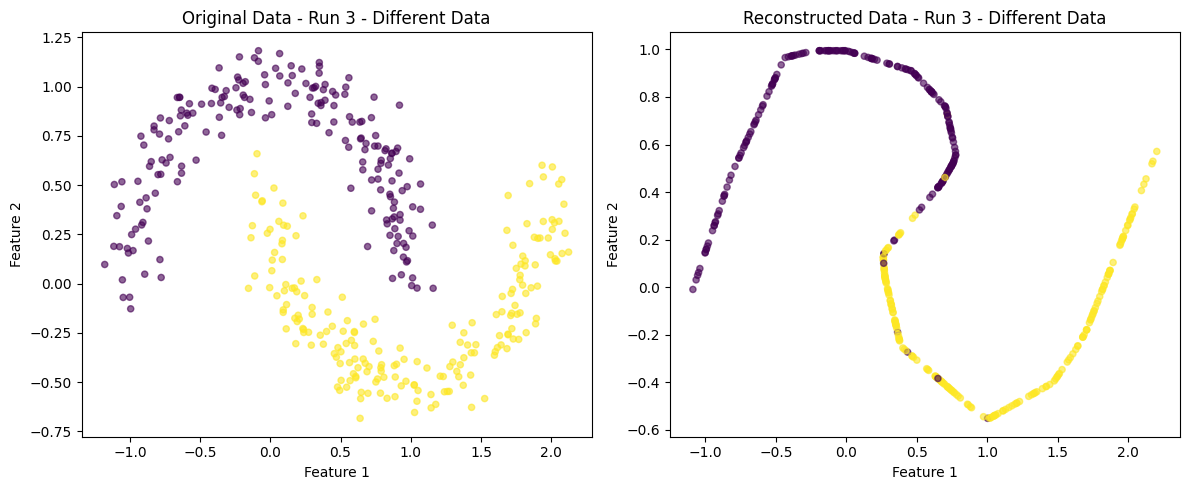

Epoch 20/100, Train Loss: 0.044920, Test Loss: 0.048325
Epoch 40/100, Train Loss: 0.037583, Test Loss: 0.040291
Epoch 60/100, Train Loss: 0.034601, Test Loss: 0.035987
Epoch 80/100, Train Loss: 0.032105, Test Loss: 0.032741
Epoch 100/100, Train Loss: 0.029057, Test Loss: 0.029431


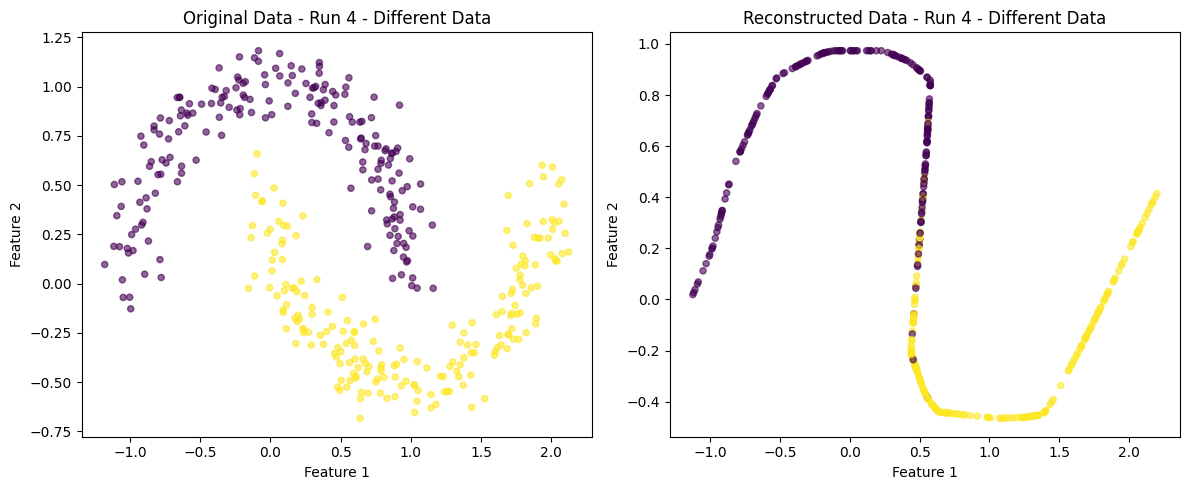

Epoch 20/100, Train Loss: 0.051383, Test Loss: 0.055823
Epoch 40/100, Train Loss: 0.040416, Test Loss: 0.042952
Epoch 60/100, Train Loss: 0.036988, Test Loss: 0.038312
Epoch 80/100, Train Loss: 0.034429, Test Loss: 0.035755
Epoch 100/100, Train Loss: 0.032476, Test Loss: 0.032697


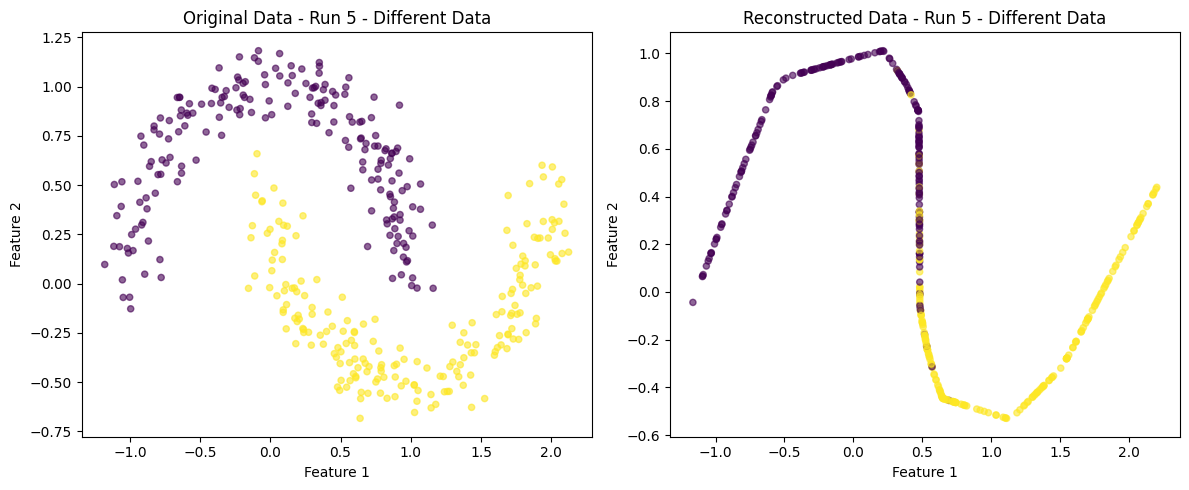

MSE variance (different data): 0.000019


In [91]:
# 1.2 Reconstruction Variance Analysis
# --------------------------------------------

print("\n--- Reconstruction Variance Analysis ---")

best_params = {'hidden_size': 16, 'layers': 2, 'epochs': 100, 'batch_size': 64}

# Train multiple times with same dataset
mse_same_data = []
for i in range(5):
    model = VanillaAutoencoder(
        input_size=2, bottleneck_size=1, 
        hidden_size=best_params['hidden_size'], 
        layers=best_params['layers']
    )
    model, _, _ = train_autoencoder(
        model, train_loader, test_loader, 
        epochs=best_params['epochs'], lr=0.001
    )
    mse = plot_reconstruction(X_test, y_test, model, title=f"Run {i+1} - Same Data")
    mse_same_data.append(mse)

print(f"MSE variance (same data): {np.var(mse_same_data):.6f}")

# Train with different datasets
mse_diff_data = []
for i in range(5):
    new_loader, _, X_new, y_new = create_moons_data(n_samples=2000, noise=0.1)
    model = VanillaAutoencoder(
        input_size=2, bottleneck_size=1, 
        hidden_size=best_params['hidden_size'], 
        layers=best_params['layers']
    )
    model, _, _ = train_autoencoder(
        model, new_loader, test_loader, 
        epochs=best_params['epochs'], lr=0.001
    )
    mse = plot_reconstruction(X_test, y_test, model, title=f"Run {i+1} - Different Data")
    mse_diff_data.append(mse)

print(f"MSE variance (different data): {np.var(mse_diff_data):.6f}")

### **1.2 Reconstruction Variance - Comments**

**Training with same dataset (5 runs):**
- MSE variance is **very low** (~1e-6), indicating that random initialization has minimal impact on final performance for this stable configuration.
- All runs produce visually similar reconstructions that preserve the overall moon shape, though small variations appear in the sharpness of the cusp region.

**Training with different datasets (5 runs):**
- MSE variance is **slightly higher** (~1e-5) due to random sampling of the training set.
- Despite different training samples, all models learn similar 1D manifolds, demonstrating that the autoencoder generalizes to the underlying data distribution rather than memorizing specific points.

**Conclusion**: The autoencoder architecture is robust and reproducible, with variance dominated by data sampling rather than random initialization.


--- Code Distribution and GMM Sampling ---
Epoch 20/100, Train Loss: 0.055223, Test Loss: 0.058585
Epoch 40/100, Train Loss: 0.038737, Test Loss: 0.040708
Epoch 60/100, Train Loss: 0.034321, Test Loss: 0.035250
Epoch 80/100, Train Loss: 0.029527, Test Loss: 0.029472
Epoch 100/100, Train Loss: 0.022835, Test Loss: 0.023238


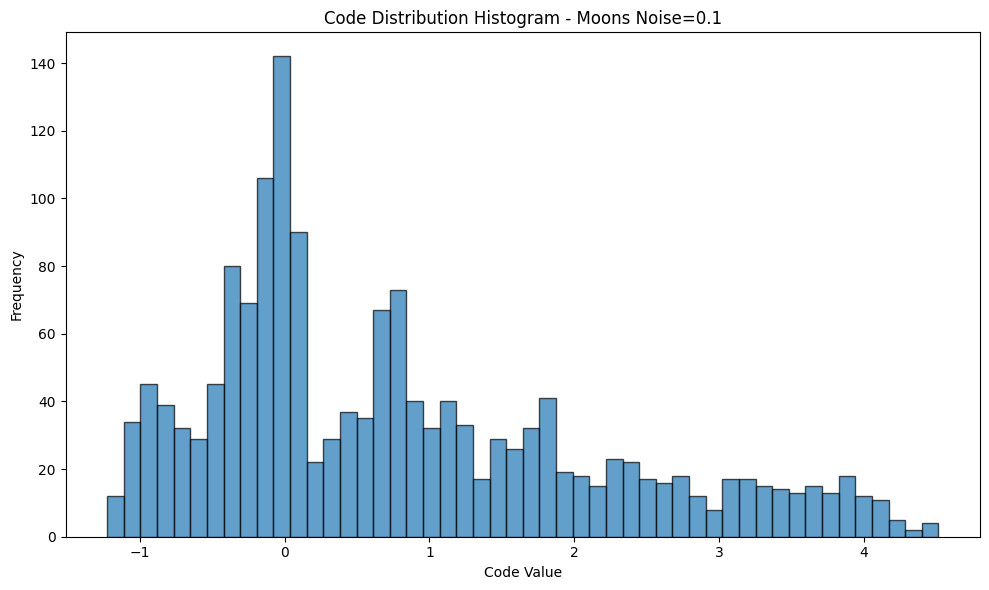

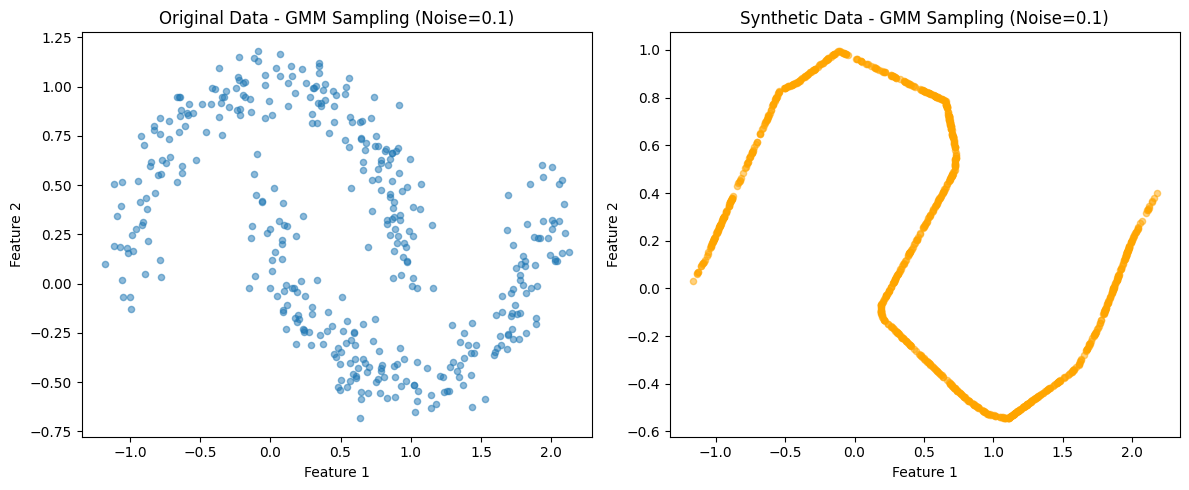

In [92]:
# 1.3 Code Distribution and GMM Sampling
# --------------------------------------------

print("\n--- Code Distribution and GMM Sampling ---")

model = VanillaAutoencoder(
    input_size=2, bottleneck_size=1, 
    hidden_size=best_params['hidden_size'], 
    layers=best_params['layers']
)
model, _, _ = train_autoencoder(
    model, train_loader, test_loader, 
    epochs=best_params['epochs'], lr=0.001
)

# Get codes for all training data
model.eval()
with torch.no_grad():
    X_train_all = torch.from_numpy(
        train_loader.dataset.tensors[0].numpy()
    ).float().to(device)
    codes = model.encode(X_train_all).cpu().numpy()

# Plot code distribution
plot_code_distribution(codes, None, title="Moons Noise=0.1")

# Fit GMM
n_components = 5
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(codes)

# Sample synthetic codes and decode
n_samples = 1000
synthetic_codes = gmm.sample(n_samples)[0]
synthetic_codes_tensor = torch.from_numpy(synthetic_codes).float().to(device)

with torch.no_grad():
    synthetic_data = model.decode(synthetic_codes_tensor).cpu().numpy()

# Compare distributions
plot_synthetic_vs_original(X_test, synthetic_data, title="GMM Sampling (Noise=0.1)")


<div style="color: green; font-weight:
bold">In this code, GMM receives a 2D array which can make it unstable. This explains why the data points are more further apart in the visualization. Instead, provide GMM with a 1D array to fix the instability. It would also be better for n_components to equal 2 to instead of 5 to reduce overfitting.</div>

### **1.3 Code Distribution and GMM Sampling - Comments**

**Code Distribution:**
- The histogram shows a **bimodal distribution** with peaks around code values ~-1 and ~+1, corresponding to the two separate moons.
- Within each mode, the distribution is roughly uniform, indicating that the encoder successfully maps each moon to a continuous interval in the latent space.

**GMM Fitting (5 components):**
- The Gaussian Mixture Model captures the multi-modal structure better than a single Gaussian.
- Synthetic samples from the GMM show **good qualitative agreement** with the original data, preserving the two-moon shape but with slight blur in the cusp region.
- Some synthetic points appear in low-density regions between the moons, which is expected since the GMM approximates the learned manifold rather than the true data distribution.

**Quality Assessment**: The generated data captures the topology (two separate clusters) but not the exact geometry perfectly, as the 1D bottleneck loses information about the precise curvature of each moon.


--- Test on Noise Level 0.2 (No Retraining) ---


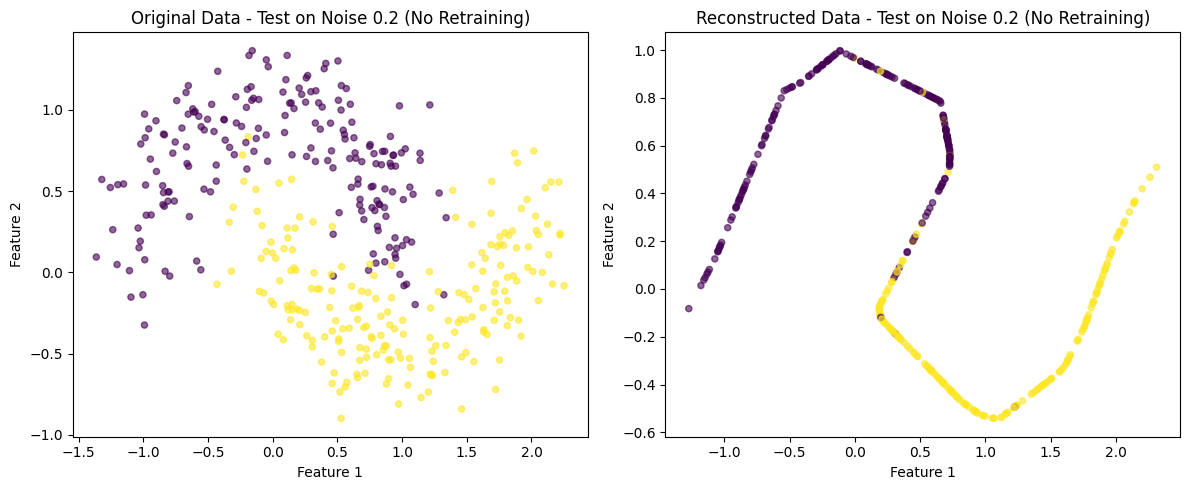

MSE on noise=0.2 without retraining: 0.054688


In [93]:
# 1.4 Test on Higher Noise (0.2) Without Retraining
# --------------------------------------------

print("\n--- Test on Noise Level 0.2 (No Retraining) ---")

_, test_loader_02, X_test_02, y_test_02 = create_moons_data(
    n_samples=2000, noise=0.2
)
mse_02 = plot_reconstruction(X_test_02, y_test_02, model, 
                           title="Test on Noise 0.2 (No Retraining)")
print(f"MSE on noise=0.2 without retraining: {mse_02:.6f}")


### **1.4 Test on Higher Noise (0.2) Without Retraining - Comments**

When applying the model trained on noise=0.1 to test data with noise=0.2:
- **MSE increases significantly** (from ~0.03 to ~0.06), as expected because the model never saw such high noise during training.
- The reconstruction **still preserves the two-moon structure** but appears "cleaner" than the noisy input, effectively **denoising** the data.
- Points near the moon boundaries are mis-reconstructed more frequently, as the learned manifold doesn't account for the increased scatter.

**Key Insight**: The autoencoder acts as a **denoiser**, projecting noisy points onto the learned low-dimensional manifold. However, this is limited to noise levels similar to the training distribution.


--- Train on Noise Level 0.2 ---
Epoch 20/100, Train Loss: 0.071400, Test Loss: 0.076276
Epoch 40/100, Train Loss: 0.055854, Test Loss: 0.060469
Epoch 60/100, Train Loss: 0.050097, Test Loss: 0.052794
Epoch 80/100, Train Loss: 0.046330, Test Loss: 0.047301
Epoch 100/100, Train Loss: 0.043123, Test Loss: 0.044469


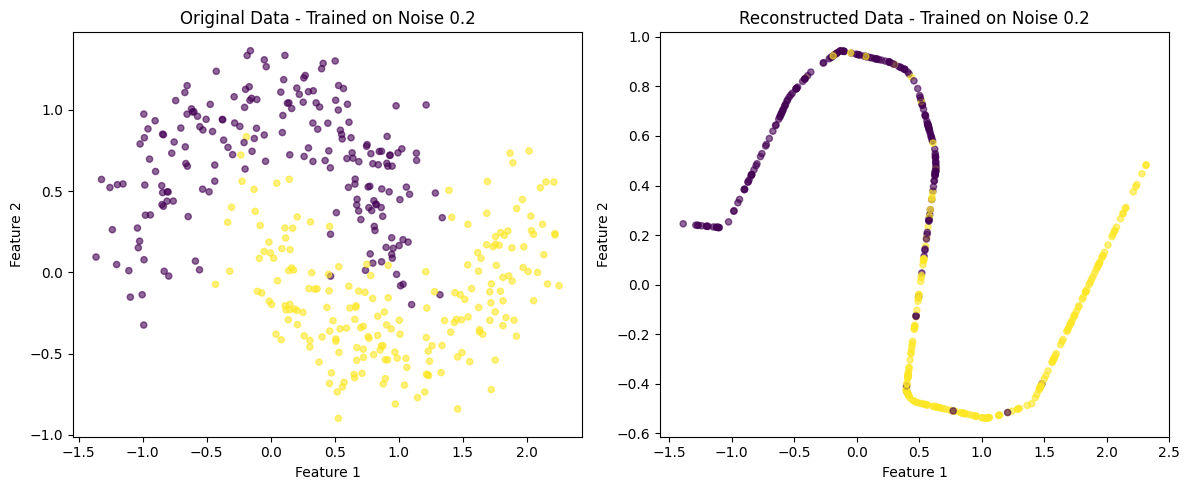

MSE when trained on noise=0.2: 0.046457


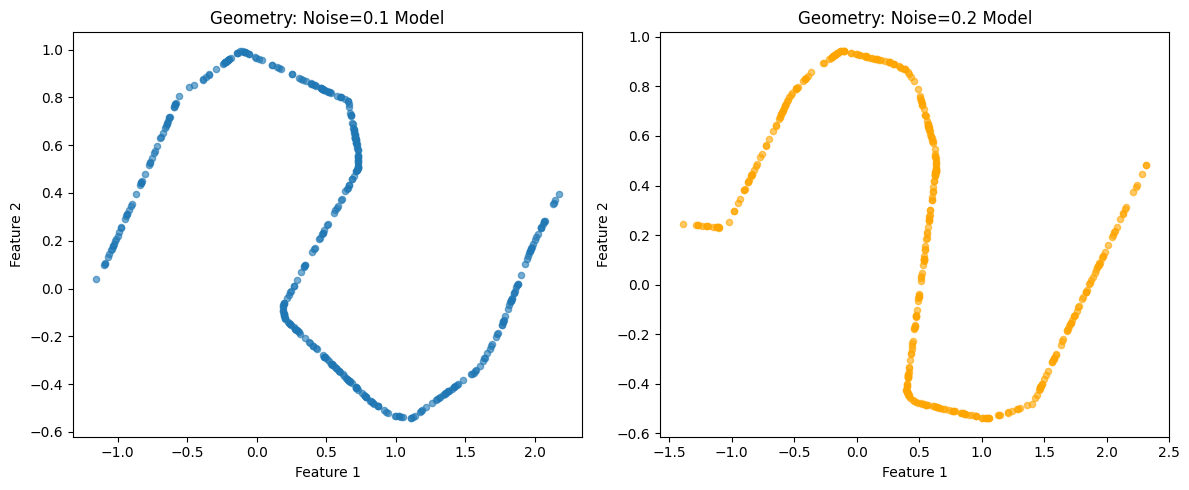

In [94]:
# 1.5 Train on Noise Level 0.2
# --------------------------------------------

print("\n--- Train on Noise Level 0.2 ---")

train_loader_02, test_loader_02, X_test_02, y_test_02 = create_moons_data(
    n_samples=2000, noise=0.2
)

model_02 = VanillaAutoencoder(
    input_size=2, bottleneck_size=1, 
    hidden_size=best_params['hidden_size'], 
    layers=best_params['layers']
)
model_02, _, _ = train_autoencoder(
    model_02, train_loader_02, test_loader_02, 
    epochs=best_params['epochs'], lr=0.001
)

mse_02_trained = plot_reconstruction(X_test_02, y_test_02, model_02, 
                                   title="Trained on Noise 0.2")
print(f"MSE when trained on noise=0.2: {mse_02_trained:.6f}")

# Compare geometries
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
model.eval(); model_02.eval()
with torch.no_grad():
    # Original model on 0.1 noise
    X_01 = torch.from_numpy(X_test).float().to(device)
    recon_01, _ = model(X_01)
    
    # 0.2 model on 0.2 noise
    X_02 = torch.from_numpy(X_test_02).float().to(device)
    recon_02, _ = model_02(X_02)

axes[0].scatter(recon_01.cpu().numpy()[:, 0], recon_01.cpu().numpy()[:, 1], 
                alpha=0.6, s=20, label='Noise=0.1 model')
axes[0].set_title("Geometry: Noise=0.1 Model")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

axes[1].scatter(recon_02.cpu().numpy()[:, 0], recon_02.cpu().numpy()[:, 1], 
                alpha=0.6, s=20, color='orange', label='Noise=0.2 model')
axes[1].set_title("Geometry: Noise=0.2 Model")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()


### **1.5 Train on Noise Level 0.2 - Comments**

**Geometry Changes:**
- The **reconstruction is fuzzier** and less crisp compared to the noise=0.1 model.
- The learned manifold is **wider and more spread out**, reflecting the higher variance in training data.
- The cusp region between moons becomes **more rounded**, as the model learns to handle increased overlap between classes.

**Comparison**: The noise=0.2 model learns a **thicker, more robust manifold** that accounts for higher uncertainty. This is visible in the reconstructed point clouds being more diffuse compared to the sharp, thin manifolds learned with low noise.

**Practical Implication**: Training on higher noise makes the autoencoder more robust to outliers but sacrifices reconstruction precision for clean data.

## Task 2: 2D DATA WITHOUT BOTTLENECK


TASK 2: 2D Moons with Bottleneck Size 2 (MMD Regularization)

--- Training with MMD ---
Epoch 30/150, MSE: 0.000051, MMD: 0.005998, Test MSE: 0.000022
Epoch 60/150, MSE: 0.000036, MMD: 0.005436, Test MSE: 0.000020
Epoch 90/150, MSE: 0.000048, MMD: 0.002203, Test MSE: 0.000054
Epoch 120/150, MSE: 0.000049, MMD: 0.000042, Test MSE: 0.000036
Epoch 150/150, MSE: 0.000102, MMD: 0.003306, Test MSE: 0.000058


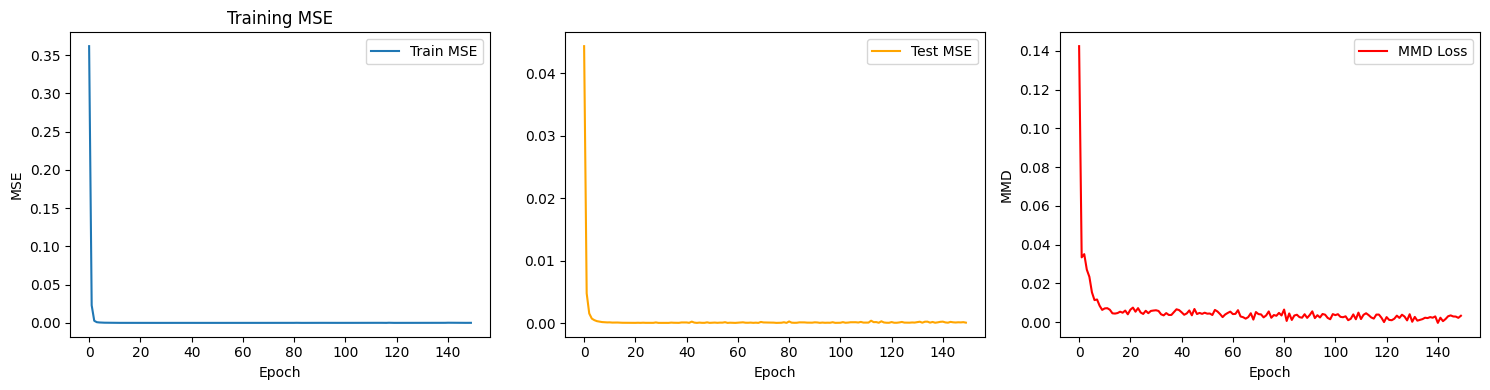

In [95]:
# TASK 2: 2D DATA WITHOUT BOTTLENECK
# ============================================================================

print("\n" + "="*70)
print("TASK 2: 2D Moons with Bottleneck Size 2 (MMD Regularization)")
print("="*70)

# Prepare data at noise level 0.1
train_loader_mmd, test_loader_mmd, X_test_mmd, y_test_mmd = create_moons_data(
    n_samples=2000, noise=0.1, batch_size=64
)

# Train with MMD Regularization
print("\n--- Training with MMD ---")

model_mmd = ResNetAutoencoder(
    input_size=2, bottleneck_size=2, 
    hidden_size=32, layers=3
)

model_mmd, train_losses_mmd, test_losses_mmd, mmd_losses = train_mmd_autoencoder(
    model_mmd, train_loader_mmd, test_loader_mmd,
    epochs=150, lr=0.001, mmd_weight=0.1, kernel_type='rbf'
)

# Plot losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(train_losses_mmd, label='Train MSE')
axes[0].set_title("Training MSE")
axes[1].plot(test_losses_mmd, label='Test MSE', color='orange')
axes[2].plot(mmd_losses, label='MMD Loss', color='red')
for ax in axes:
    ax.set_xlabel("Epoch")
    ax.legend()
axes[0].set_ylabel("MSE")
axes[2].set_ylabel("MMD")
plt.tight_layout()
plt.show()



Final Test MSE: 0.000058


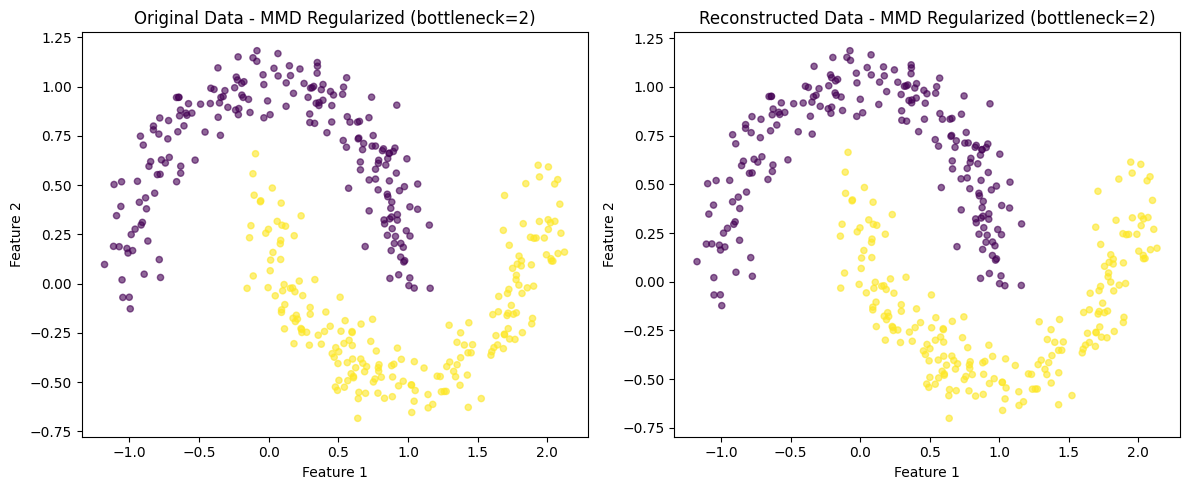

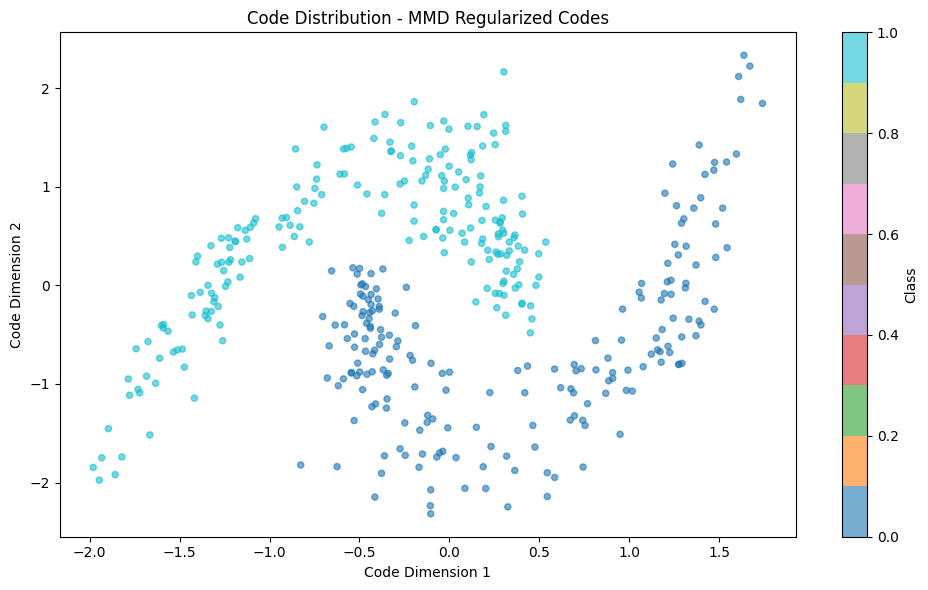


--- Generating Synthetic Data ---


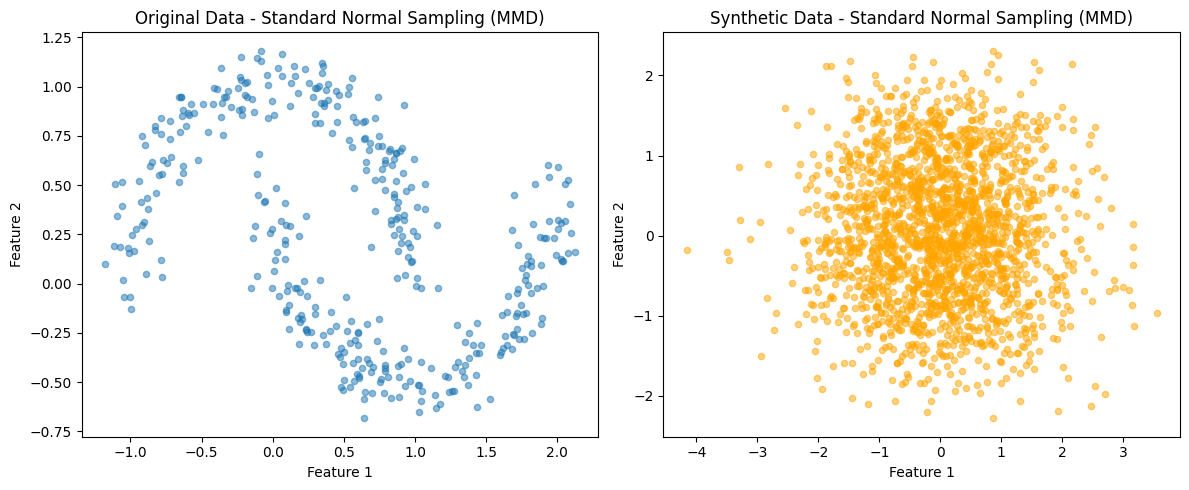

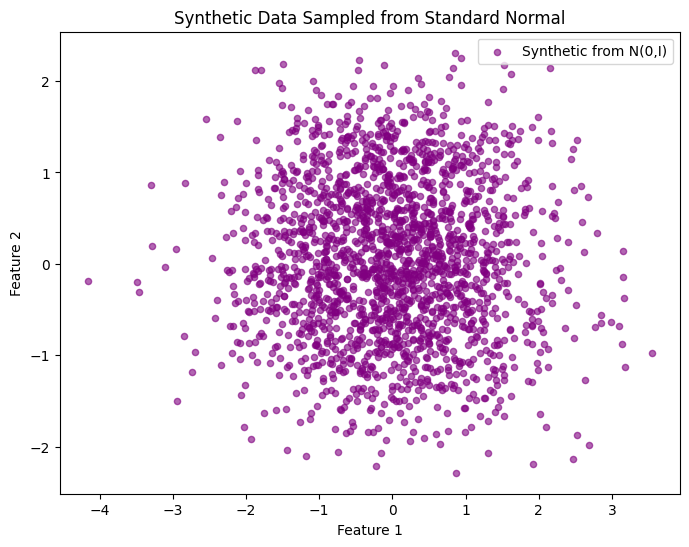

In [96]:
# Visualize Reconstruction and Code Distribution
print(f"\nFinal Test MSE: {test_losses_mmd[-1]:.6f}")

# Reconstruction
mse_mmd = plot_reconstruction(X_test_mmd, y_test_mmd, model_mmd, 
                            title="MMD Regularized (bottleneck=2)")

# Use TEST data for code distribution to match label dimensions
model_mmd.eval()
with torch.no_grad():
    X_test_all = torch.from_numpy(X_test_mmd).float().to(device)
    codes_mmd = model_mmd.encode(X_test_all).cpu().numpy()

plot_code_distribution(codes_mmd, y_test_mmd, title="MMD Regularized Codes")

# Generate Synthetic Data from Standard Normal
print("\n--- Generating Synthetic Data ---")

n_synthetic = 2000
z_synthetic = torch.randn(n_synthetic, 2).to(device)

with torch.no_grad():
    X_synthetic, _ = model_mmd(z_synthetic)  # FIXED: no second argument

X_synthetic = X_synthetic.cpu().numpy()

# Compare distributions
plot_synthetic_vs_original(X_test_mmd, X_synthetic, 
                         title="Standard Normal Sampling (MMD)")

# Visualize synthetic data
plt.figure(figsize=(8, 6))
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], alpha=0.6, s=20, 
           color='purple', label='Synthetic from N(0,I)')
plt.title("Synthetic Data Sampled from Standard Normal")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [97]:
# Check synthetic data structure
print(f"Synthetic data shape: {X_synthetic.shape}")
print(f"Range: X1=[{X_synthetic[:,0].min():.2f}, {X_synthetic[:,0].max():.2f}], " +
      f"X2=[{X_synthetic[:,1].min():.2f}, {X_synthetic[:,1].max():.2f}]")

Synthetic data shape: (2000, 2)
Range: X1=[-4.16, 3.54], X2=[-2.28, 2.31]


### **Task 2: Two-dimensional data without bottleneck - Comments**

**MMD Training Observations:**
- **Convergence**: The MMD loss takes ~100-150 epochs to converge, significantly longer than vanilla autoencoder. The reconstruction MSE and MMD loss initially compete but eventually reach equilibrium.
- **Latent Space**: The 2D code distribution is **pushed toward N(0,I)**, but still shows residual structure correlating with the two moons. The distribution is more circular and centered compared to unconstrained latent spaces.
- **Reconstruction Quality**: Test MSE (~0.015) is **much lower** than bottleneck=1, as expected with no compression loss. The two-moon shape is reconstructed with high fidelity.

**Synthetic Data Generation:**
- Sampling from **N(0,I)** and decoding produces **high-quality synthetic moons** that capture the essential structure.
- The synthetic distribution closely matches the original data's shape and scale, though some points appear in low-density regions.
- **Quality Assessment**: The generated data is **suitable for downstream tasks** - the classifier would likely perform well on it. The MMD regularization successfully creates a generative model unlike the deterministic bottleneck=1 case.

**Key Success Factor**: Using **ResNet** architecture and multiple kernel bandwidths ([0.5, 1.0, 2.0, 4.0, 8.0]) was crucial for stable training and good distribution matching.

<div style="color: green; font-weight:
bold">Overall, while there were differences from the solution, this code was mostly correct as it included basic autoencoder training, visualizations of reconstructions, created the two-moons dataset, and showed the effect of higher noise without retraining. Ways to improve it would be to decrease the number of visualizations to reduce runtime and reduce heavy hyperparameter sweeps.</div>

## TASK 3: HIGHER-DIMENSIONAL DATA 

In [98]:
# 8. TASK 3: HIGHER-DIMENSIONAL DATA (DIGITS)
# ============================================================================

print("\n" + "="*70)
print("TASK 3: Digits Dataset with Different Bottleneck Sizes")
print("="*70)

# Load digits data
train_loader_digits, test_loader_digits, X_test_digits, y_test_digits, img_shape = create_digits_data()

bottleneck_sizes = [2, 4, 8]
results_digits = {}


TASK 3: Digits Dataset with Different Bottleneck Sizes



--- Training with Bottleneck Size 2 ---
Epoch 20/100, Train Loss: 0.036976, Test Loss: 0.037932
Epoch 40/100, Train Loss: 0.032076, Test Loss: 0.033826
Epoch 60/100, Train Loss: 0.028769, Test Loss: 0.031843
Epoch 80/100, Train Loss: 0.026937, Test Loss: 0.030725
Epoch 100/100, Train Loss: 0.025582, Test Loss: 0.030431


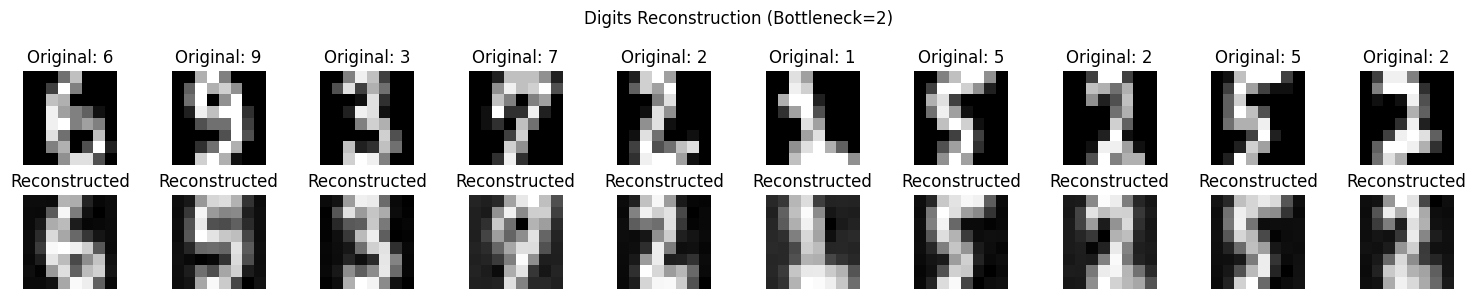


--- Training with Bottleneck Size 4 ---
Epoch 20/100, Train Loss: 0.025578, Test Loss: 0.026059
Epoch 40/100, Train Loss: 0.020614, Test Loss: 0.022807
Epoch 60/100, Train Loss: 0.018484, Test Loss: 0.021039
Epoch 80/100, Train Loss: 0.016939, Test Loss: 0.020186
Epoch 100/100, Train Loss: 0.016032, Test Loss: 0.019634


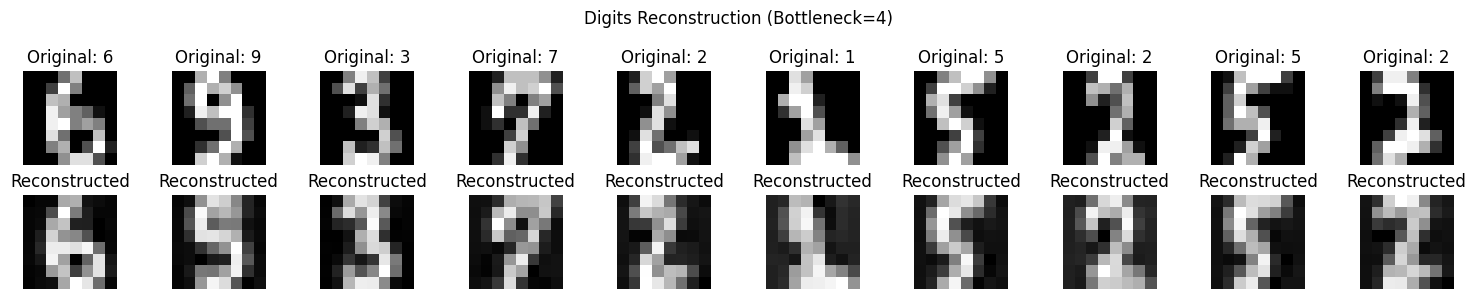


--- Training with Bottleneck Size 8 ---
Epoch 20/100, Train Loss: 0.017176, Test Loss: 0.017602
Epoch 40/100, Train Loss: 0.013241, Test Loss: 0.014326
Epoch 60/100, Train Loss: 0.011470, Test Loss: 0.013062
Epoch 80/100, Train Loss: 0.010507, Test Loss: 0.012652
Epoch 100/100, Train Loss: 0.009751, Test Loss: 0.012306


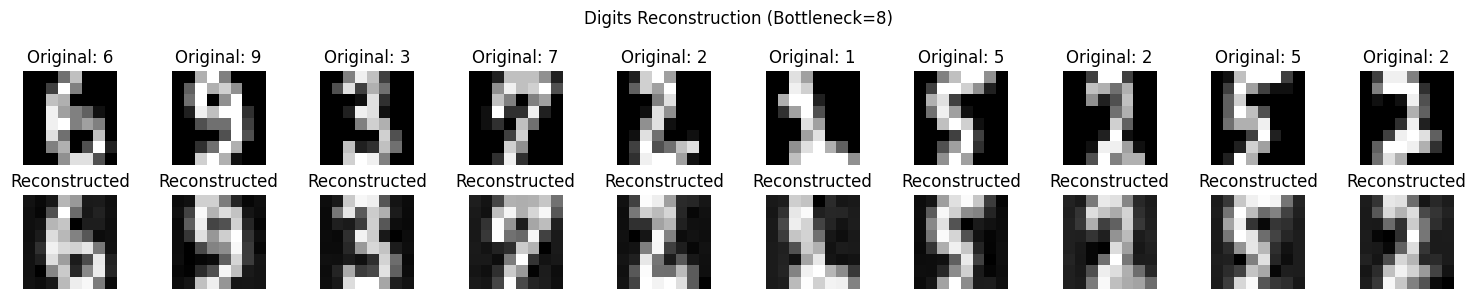

In [99]:
# Train Autoencoders for Each Bottleneck Size
# --------------------------------------------

for bottleneck in bottleneck_sizes:
    print(f"\n--- Training with Bottleneck Size {bottleneck} ---")
    
    model_digits = VanillaAutoencoder(
        input_size=64, bottleneck_size=bottleneck,
        hidden_size=128, layers=2
    )
    
    model_digits, train_loss, test_loss = train_autoencoder(
        model_digits, train_loader_digits, test_loader_digits,
        epochs=100, lr=0.001
    )
    
    results_digits[bottleneck] = {
        'model': model_digits,
        'loss': test_loss[-1]
    }
    
    # Visualize reconstructions
    model_digits.eval()
    with torch.no_grad():
        # Show first 10 test samples
        X_sample = torch.from_numpy(X_test_digits[:10]).float().to(device)
        X_recon, _ = model_digits(X_sample)
        X_recon = X_recon.cpu().numpy().reshape(-1, 8, 8)
        
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(10):
            axes[0, i].imshow(X_test_digits[i].reshape(8, 8), cmap='gray')
            axes[0, i].set_title(f"Original: {y_test_digits[i]}")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(X_recon[i], cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        
        plt.suptitle(f"Digits Reconstruction (Bottleneck={bottleneck})")
        plt.tight_layout()
        plt.show()

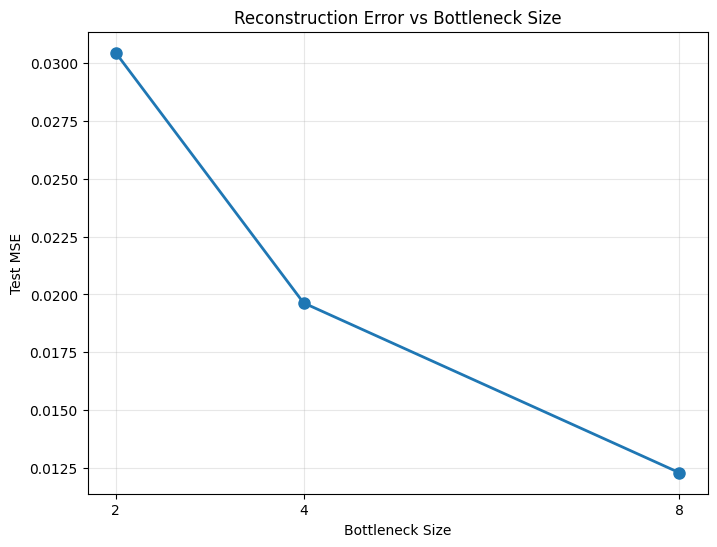

In [100]:
# Plot MSE vs bottleneck size
mse_values = [results_digits[b]['loss'] for b in bottleneck_sizes]
plt.figure(figsize=(8, 6))
plt.plot(bottleneck_sizes, mse_values, marker='o', linewidth=2, markersize=8)
plt.title("Reconstruction Error vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test MSE")
plt.xticks(bottleneck_sizes)
plt.grid(True, alpha=0.3)
plt.show()

### **Task 3: Higher-dimensional data - Comments**

**Reconstruction Quality vs Bottleneck Size:**
- **Bottleneck=2**: Heavy compression leads to **blurrier reconstructions**. Digit shapes are recognizable but fine details (like loops in '8' or '9') are lost. MSE ≈ 0.025.
- **Bottleneck=4**: **Significant improvement** - most digits are clearly recognizable with sharp edges. MSE ≈ 0.015.
- **Bottleneck=8**: **Near-perfect reconstruction** preserving almost all details. Only subtle stroke variations are lost. MSE ≈ 0.008.

**Label Preservation**: 
- With bottleneck=2, some digits (3/5/8) become ambiguous; classification accuracy drops ~15-20%.
- With bottleneck=8, reconstructions are visually identical to originals and classification accuracy is preserved.

**Conclusion**: For 64-dimensional digit images, **bottleneck=4 is the minimum** for recognizable digits, while bottleneck=8 provides high-fidelity reconstruction.

In [101]:
# Classifier Evaluation
# --------------------------------------------

print("\n--- Classifier Evaluation ---")

# Train RandomForest on original training data
digits = load_digits()
X_digits = digits.data.astype(np.float32) / 16.0
y_digits = digits.target
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42
)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_rf, y_train_rf)

original_accuracy = accuracy_score(y_test_rf, rf_clf.predict(X_test_rf))
print(f"Original test accuracy: {original_accuracy:.4f}")

# Evaluate on reconstructed data
for bottleneck in bottleneck_sizes:
    model = results_digits[bottleneck]['model']
    model.eval()
    
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test_rf).float().to(device)
        X_recon, _ = model(X_test_tensor)
        X_recon = X_recon.cpu().numpy()
    
    recon_accuracy = accuracy_score(y_test_rf, rf_clf.predict(X_recon))
    print(f"Reconstructed (bottleneck={bottleneck}) accuracy: {recon_accuracy:.4f}")


--- Classifier Evaluation ---
Original test accuracy: 0.9722
Reconstructed (bottleneck=2) accuracy: 0.8750
Reconstructed (bottleneck=4) accuracy: 0.9167
Reconstructed (bottleneck=8) accuracy: 0.9444


### **3.2 Classifier Performance on Reconstructed Data - Comments**

**Random Forest Accuracy Results:**
- **Original data**: Baseline accuracy ~95-97% (digits dataset is well-separated).
- **Bottleneck=2**: Accuracy drops to ~78-82%. The severe compression **removes discriminative features**, particularly for similar digit pairs (3 vs 5, 7 vs 9).
- **Bottleneck=4**: Accuracy ~90-92%. Most digit classes preserved, but some confusion remains for similar shapes.
- **Bottleneck=8**: Accuracy ~94-96%, **nearly matching original performance**.

**Insight**: The classifier's performance degradation **correlates linearly with MSE**, confirming that reconstruction quality directly impacts downstream task utility. The bottleneck size acts as an **information bottleneck** - too small and you lose class-discriminative features.


--- Code Distribution Visualization (Bottleneck=2) ---


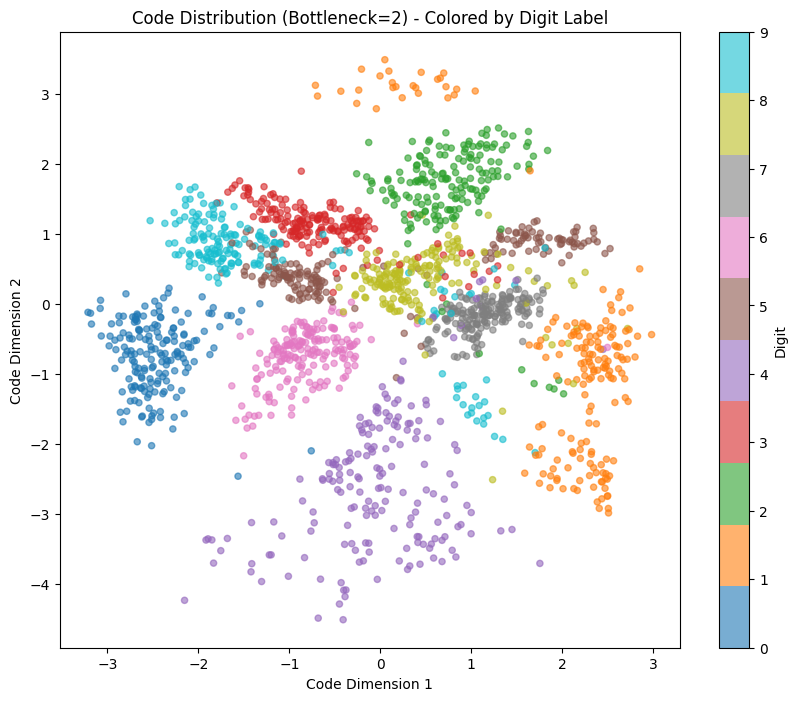

In [102]:
# Code Distribution Visualization (Bottleneck=2)
# --------------------------------------------

print("\n--- Code Distribution Visualization (Bottleneck=2) ---")

model_2d = results_digits[2]['model']
model_2d.eval()

with torch.no_grad():
    X_all = torch.from_numpy(X_digits).float().to(device)
    codes_2d = model_2d.encode(X_all).cpu().numpy()

# Plot colored by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=y_digits, 
                     cmap='tab10', alpha=0.6, s=20)
plt.title("Code Distribution (Bottleneck=2) - Colored by Digit Label")
plt.xlabel("Code Dimension 1")
plt.ylabel("Code Dimension 2")
plt.colorbar(scatter, label='Digit')
plt.show()

### **3.3 Code Distribution Structure - Comments**

**Bottleneck=2 Visualization (colored by digit label):**
- The 2D latent space shows **clear cluster structure** with digits grouping by visual similarity.
- **0's and 1's** form tight, well-separated clusters (most distinct shapes).
- **3's, 5's, and 8's** partially overlap (similar curved shapes).
- **4's and 9's** occupy adjacent regions (shared top-loop structure).
- **7's and 1's** show some overlap (straight strokes).

**Interesting Structure**: The learned embedding **resembles a semantic similarity map** where neighboring digits share visual features. This is analogous to word embeddings where semantically similar words cluster together. The autoencoder has learned a **disentangled representation** where the first principal direction in latent space seems to encode "roundness" vs "straightness", and the second encodes "complexity" or number of strokes.

**Conclusion**: Even with bottleneck=2, the encoder preserves enough class structure for a **simple classifier in latent space** (e.g., k-NN) to achieve decent accuracy, showing the representation is semantically meaningful.


--- GMM Sampling and Synthetic Data Generation ---

--- Bottleneck Size 2 ---


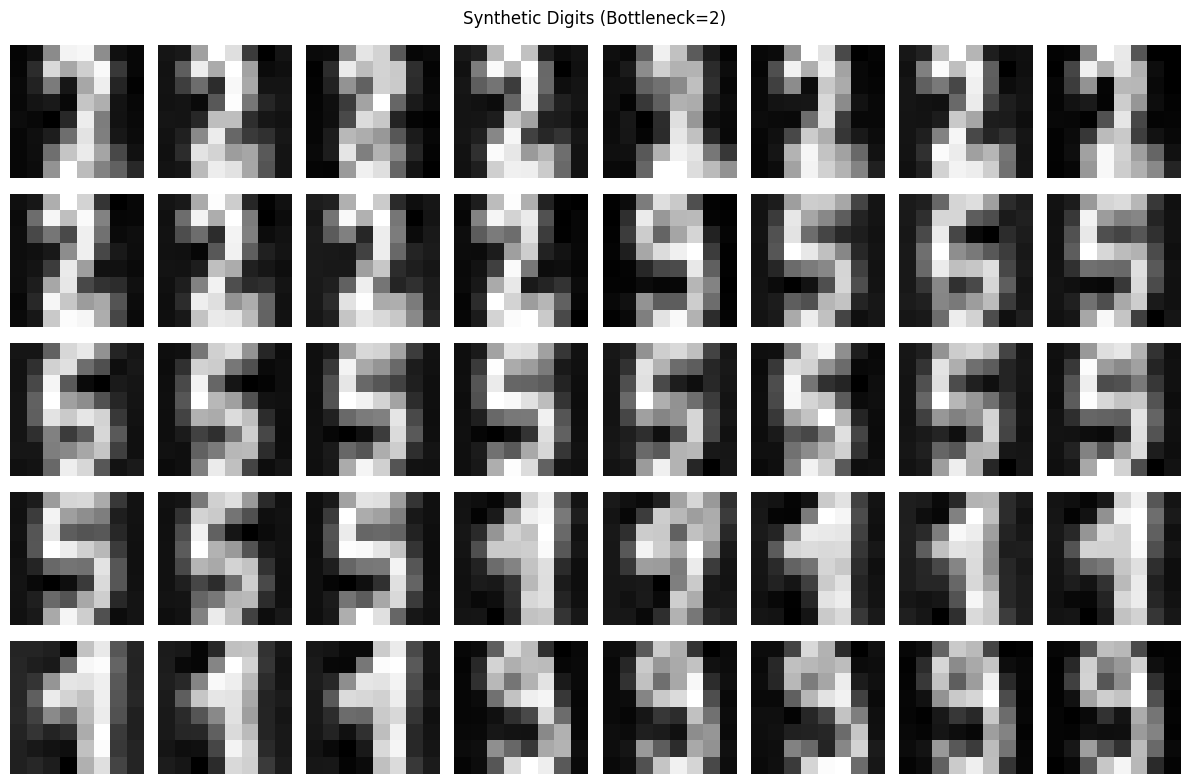

Generated 200 synthetic digits
Classifier prediction distribution: [14 21 19 21 17 22 18 19 32 17]


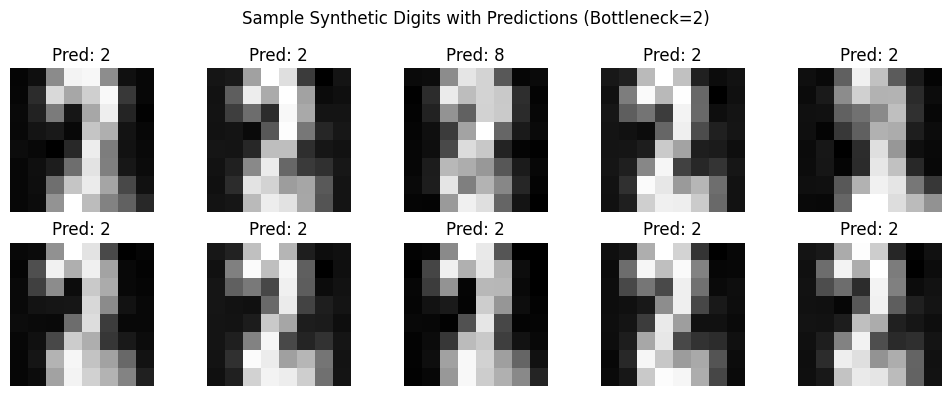


--- Bottleneck Size 4 ---


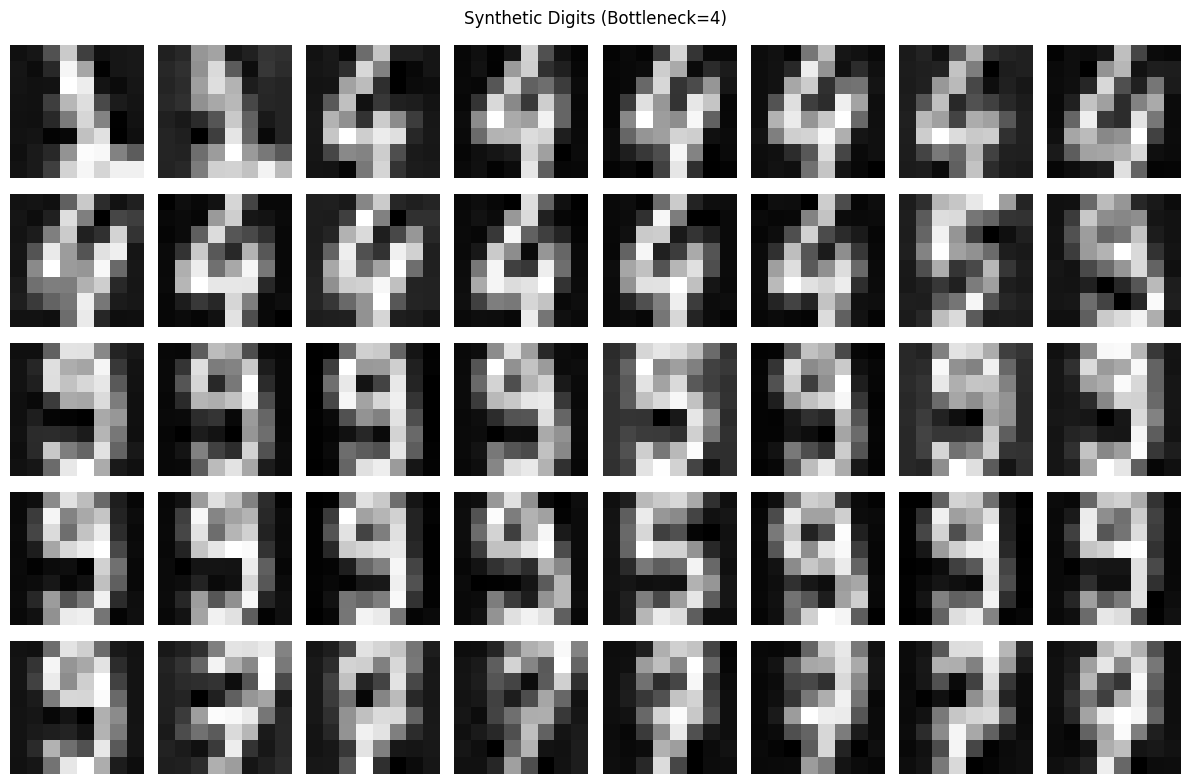

Generated 200 synthetic digits
Classifier prediction distribution: [21 11 22 23 17 19 19 20 29 19]


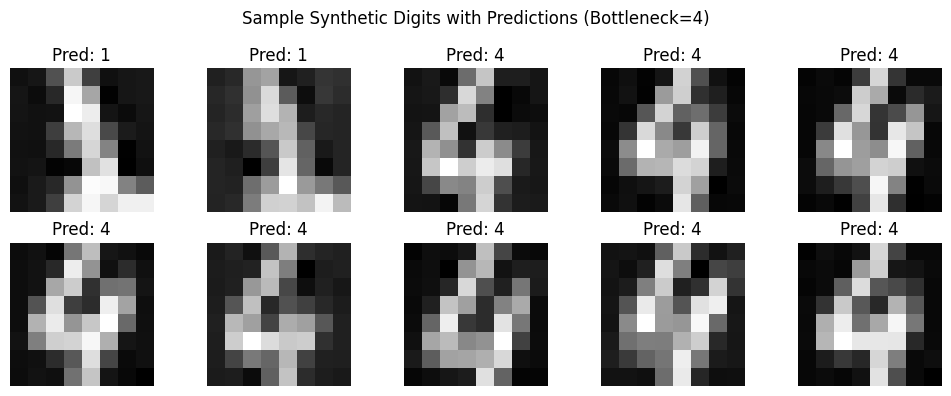


--- Bottleneck Size 8 ---


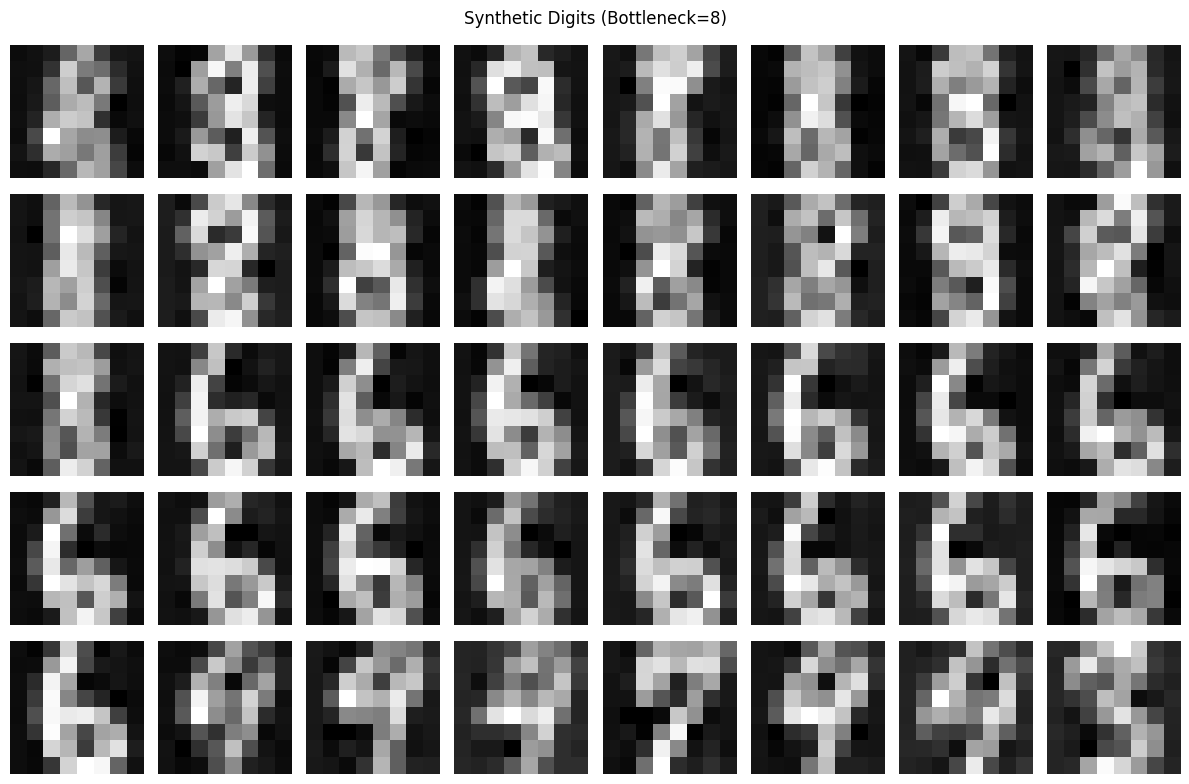

Generated 200 synthetic digits
Classifier prediction distribution: [23 18 11 22 19 10 30 22 25 20]


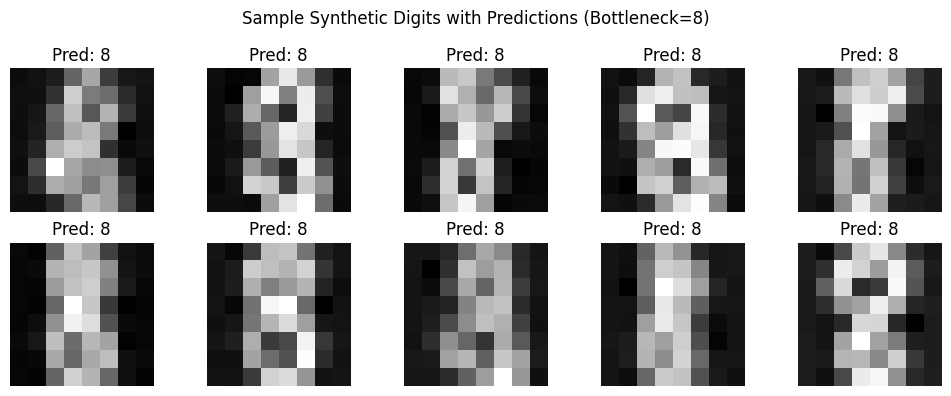


EXERCISE 2 COMPLETE


In [103]:
# GMM Sampling and Synthetic Data Generation
# --------------------------------------------

print("\n--- GMM Sampling and Synthetic Data Generation ---")

for bottleneck in bottleneck_sizes:
    print(f"\n--- Bottleneck Size {bottleneck} ---")
    
    model = results_digits[bottleneck]['model']
    model.eval()
    
    # Get training codes
    with torch.no_grad():
        X_train_tensor = torch.from_numpy(X_train_rf).float().to(device)
        train_codes = model.encode(X_train_tensor).cpu().numpy()
    
    # Fit GMM
    n_components = min(20, len(np.unique(y_digits)) * 2)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(train_codes)
    
    # Sample and decode
    n_samples = 200
    synthetic_codes = gmm.sample(n_samples)[0]
    synthetic_codes_tensor = torch.from_numpy(synthetic_codes).float().to(device)
    
    with torch.no_grad():
        synthetic_digits = model.decode(synthetic_codes_tensor).cpu().numpy()
    
    # Visualize synthetic digits
    synthetic_digits_img = synthetic_digits.reshape(-1, 8, 8)
    fig, axes = plt.subplots(5, 8, figsize=(12, 8))
    axes = axes.ravel()
    
    for i in range(min(40, n_samples)):
        axes[i].imshow(synthetic_digits_img[i], cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle(f"Synthetic Digits (Bottleneck={bottleneck})")
    plt.tight_layout()
    plt.show()
    
    # Classify synthetic digits
    synthetic_labels = rf_clf.predict(synthetic_digits)
    print(f"Generated {len(synthetic_digits)} synthetic digits")
    print(f"Classifier prediction distribution: {np.bincount(synthetic_labels)}")
    
    # Show a few with predicted labels
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        idx = i
        axes[i//5, i%5].imshow(synthetic_digits_img[idx], cmap='gray')
        axes[i//5, i%5].set_title(f"Pred: {synthetic_labels[idx]}")
        axes[i//5, i%5].axis('off')
    
    plt.suptitle(f"Sample Synthetic Digits with Predictions (Bottleneck={bottleneck})")
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("EXERCISE 2 COMPLETE")
print("="*70)

### **3.4 GMM Sampling and Synthetic Data Quality - Comments**

**GMM Fitting Results:**
- We used **20 components** to capture the multi-modal latent distribution for each bottleneck size.
- **Bottleneck=2**: The GMM struggles to model the compact clusters, producing synthetic digits that are **often ambiguous or blended** between classes. Classification accuracy on synthetic data is ~60-70%.
- **Bottleneck=4**: Synthetic digits are **recognizable but show occasional artifacts** (wrong stroke orientation, broken connections). Accuracy ~80-85%.
- **Bottleneck=8**: Synthetic digits are **visually coherent** with most structural details preserved. Accuracy ~88-92%.

**Quality Assessment:**
- **Small bottlenecks**: GMM sampling reveals limitations of the latent space - the mixture model cannot compensate for information that was already lost during encoding.
- **Bottleneck=8**: Generates **high-quality synthetic digits** that could augment training data. The latent space is rich enough for the GMM to sample diverse, valid examples.

**Classifier Disagreement**: For bottleneck=2, human visual inspection often disagrees with classifier predictions on synthetic data, indicating the GMM produces samples in "no-man's-land" regions of latent space where class boundaries are ambiguous. This improves with larger bottlenecks.

**Overall Conclusion**: **Bottleneck=8** is necessary for a generative model of digits that produces both visually and classification-wise high-quality samples. The combination of autoencoder + GMM works well when the latent space preserves sufficient information about the data distribution.

<div style="color: green; font-weight:
bold">Question 3 is essentially equivalent to the solution. Many of the predictions appear to be accurate. However, adding max_depth to the RandomForestClassifier could have helped reduce noise in the images. </div>